1. 读数据data,  data.info()
2. 检查重复行
3. 检查缺失值， CID缺失删除
4. 计算R\F\M
   M=   按客户号分组 计算 SUM(单价*数量）  
 去掉退货单：
   F=     按客户号分组 计算 COUNT(不重复的订单日期）  
   R=    指定的日期- 按客户号分组 计算 MAX(订单日期）

5. R\F\M的描述性信息、可视化：直方图， 三维三点图

6. R\F\M 标准化处理     检查离群点 （顺序不限）
7. 确定K
8. 配置模型、训练模型
9.  模型结果：分成几类，各类的质心，每个顾客属于哪一类
10. 模型可视化  三维R、F、M的散点图，每类不同颜色，最好也能标出质心。
11. 模型评价（轮廓系数等，如果前面确定K的时候做过，可以省略，简单介绍就行）
12. 结合RFM模型 给各类贴标签：高价值顾客、一般顾客等等。。。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams["font.family"]=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%matplotlib inline

In [2]:
df = pd.read_csv("customer_data.csv")

In [3]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom  
...                 ...        ...         ...             ...  
541904  12/9/2011 12:50       0.85     12680.0          France  
541905  12/9/2011 12:50       2.10     12680.0          France  
541906  12/9/2011 12:50       4.15     12680.0          France  
541907  12/9/2011 12:50       4.15     12680.0          France  
541908  12/9/2011 12:50       4.95     12680.0          France  

[541909 rows x 8 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
duplicated_df = df.duplicated(keep='first')
removed_rows = df[duplicated_df]
print('重复的行:')
print(removed_rows)
df = df.drop_duplicates()

重复的行:
       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

            InvoiceDate  UnitPrice  CustomerID         Country  
517     12/1/2010 11:45     

In [6]:
df = df.drop(columns=['StockCode','Country','Description'],axis=1)

In [7]:
df

InvoiceNo  Quantity      InvoiceDate  UnitPrice  CustomerID
0         536365         6   12/1/2010 8:26       2.55     17850.0
1         536365         6   12/1/2010 8:26       3.39     17850.0
2         536365         8   12/1/2010 8:26       2.75     17850.0
3         536365         6   12/1/2010 8:26       3.39     17850.0
4         536365         6   12/1/2010 8:26       3.39     17850.0
...          ...       ...              ...        ...         ...
541904    581587        12  12/9/2011 12:50       0.85     12680.0
541905    581587         6  12/9/2011 12:50       2.10     12680.0
541906    581587         4  12/9/2011 12:50       4.15     12680.0
541907    581587         4  12/9/2011 12:50       4.15     12680.0
541908    581587         3  12/9/2011 12:50       4.95     12680.0

[536641 rows x 5 columns]

In [8]:
# 检测空值
null_values = df.isnull().sum()
# 描述性统计数据
desc_stats = df.describe().round(2)
print('\n空值：')
print(null_values)
print('\n描述性统计数据：')
print(desc_stats)


空值：
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
dtype: int64

描述性统计数据：
        Quantity  UnitPrice  CustomerID
count  536641.00  536641.00   401604.00
mean        9.62       4.63    15281.16
std       219.13      97.23     1714.01
min    -80995.00  -11062.06    12346.00
25%         1.00       1.25    13939.00
50%         3.00       2.08    15145.00
75%        10.00       4.13    16784.00
max     80995.00   38970.00    18287.00


In [9]:
negative_quantity = df[df['Quantity'] <= 0]
print('Quantity 为小于等于0的行：')
print(negative_quantity)
negative_unit_price = df[df['UnitPrice'] <= 0]
print('\nUnitPrice 为小于等于0的行：')
print(negative_unit_price)
null_customer_id = df[df['CustomerID'].isnull()]
print('\nCustomerID 为空值的行：')
print(null_customer_id)

Quantity 为小于等于0的行：
       InvoiceNo  Quantity      InvoiceDate  UnitPrice  CustomerID
141      C536379        -1   12/1/2010 9:41      27.50     14527.0
154      C536383        -1   12/1/2010 9:49       4.65     15311.0
235      C536391       -12  12/1/2010 10:24       1.65     17548.0
236      C536391       -24  12/1/2010 10:24       0.29     17548.0
237      C536391       -24  12/1/2010 10:24       0.29     17548.0
...          ...       ...              ...        ...         ...
540449   C581490       -11   12/9/2011 9:57       0.83     14397.0
541541   C581499        -1  12/9/2011 10:28     224.69     15498.0
541715   C581568        -5  12/9/2011 11:57      10.95     15311.0
541716   C581569        -1  12/9/2011 11:58       1.25     17315.0
541717   C581569        -5  12/9/2011 11:58       1.25     17315.0

[10587 rows x 5 columns]

UnitPrice 为小于等于0的行：
       InvoiceNo  Quantity      InvoiceDate  UnitPrice  CustomerID
622       536414        56  12/1/2010 11:52        0.0         

In [10]:
df = df.drop(df[df['CustomerID'].isnull()].index,axis=0)

In [11]:
df

InvoiceNo  Quantity      InvoiceDate  UnitPrice  CustomerID
0         536365         6   12/1/2010 8:26       2.55     17850.0
1         536365         6   12/1/2010 8:26       3.39     17850.0
2         536365         8   12/1/2010 8:26       2.75     17850.0
3         536365         6   12/1/2010 8:26       3.39     17850.0
4         536365         6   12/1/2010 8:26       3.39     17850.0
...          ...       ...              ...        ...         ...
541904    581587        12  12/9/2011 12:50       0.85     12680.0
541905    581587         6  12/9/2011 12:50       2.10     12680.0
541906    581587         4  12/9/2011 12:50       4.15     12680.0
541907    581587         4  12/9/2011 12:50       4.15     12680.0
541908    581587         3  12/9/2011 12:50       4.95     12680.0

[401604 rows x 5 columns]

In [12]:
# InvoiceNo中以 'C' 开头的行以及对应的下单行
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
c_start_rows = df['InvoiceNo'].str.startswith('C')
related_invoice_nos = df[c_start_rows]['InvoiceNo'].str[1:]
related_rows = df['InvoiceNo'].isin(related_invoice_nos)

## 计算M:计算Quantity和UnitPrice的乘积，直接根据CustomerID分组计算总的金额

In [13]:
group = df.groupby('CustomerID')

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary = group['TotalPrice'].sum().rename('Monetary').to_frame().reset_index()
monetary

CustomerID  Monetary
0        12346.0      0.00
1        12347.0   4310.00
2        12348.0   1797.24
3        12349.0   1757.55
4        12350.0    334.40
...          ...       ...
4367     18280.0    180.60
4368     18281.0     80.82
4369     18282.0    176.60
4370     18283.0   2045.53
4371     18287.0   1837.28

[4372 rows x 2 columns]

In [14]:
monetary.to_excel('monetary.xlsx')

       CustomerID   Monetary
count     4372.00    4372.00
mean     15299.68    1893.53
std       1722.39    8218.70
min      12346.00   -4287.63
25%      13812.75     291.79
50%      15300.50     644.07
75%      16778.25    1608.34
max      18287.00  279489.02


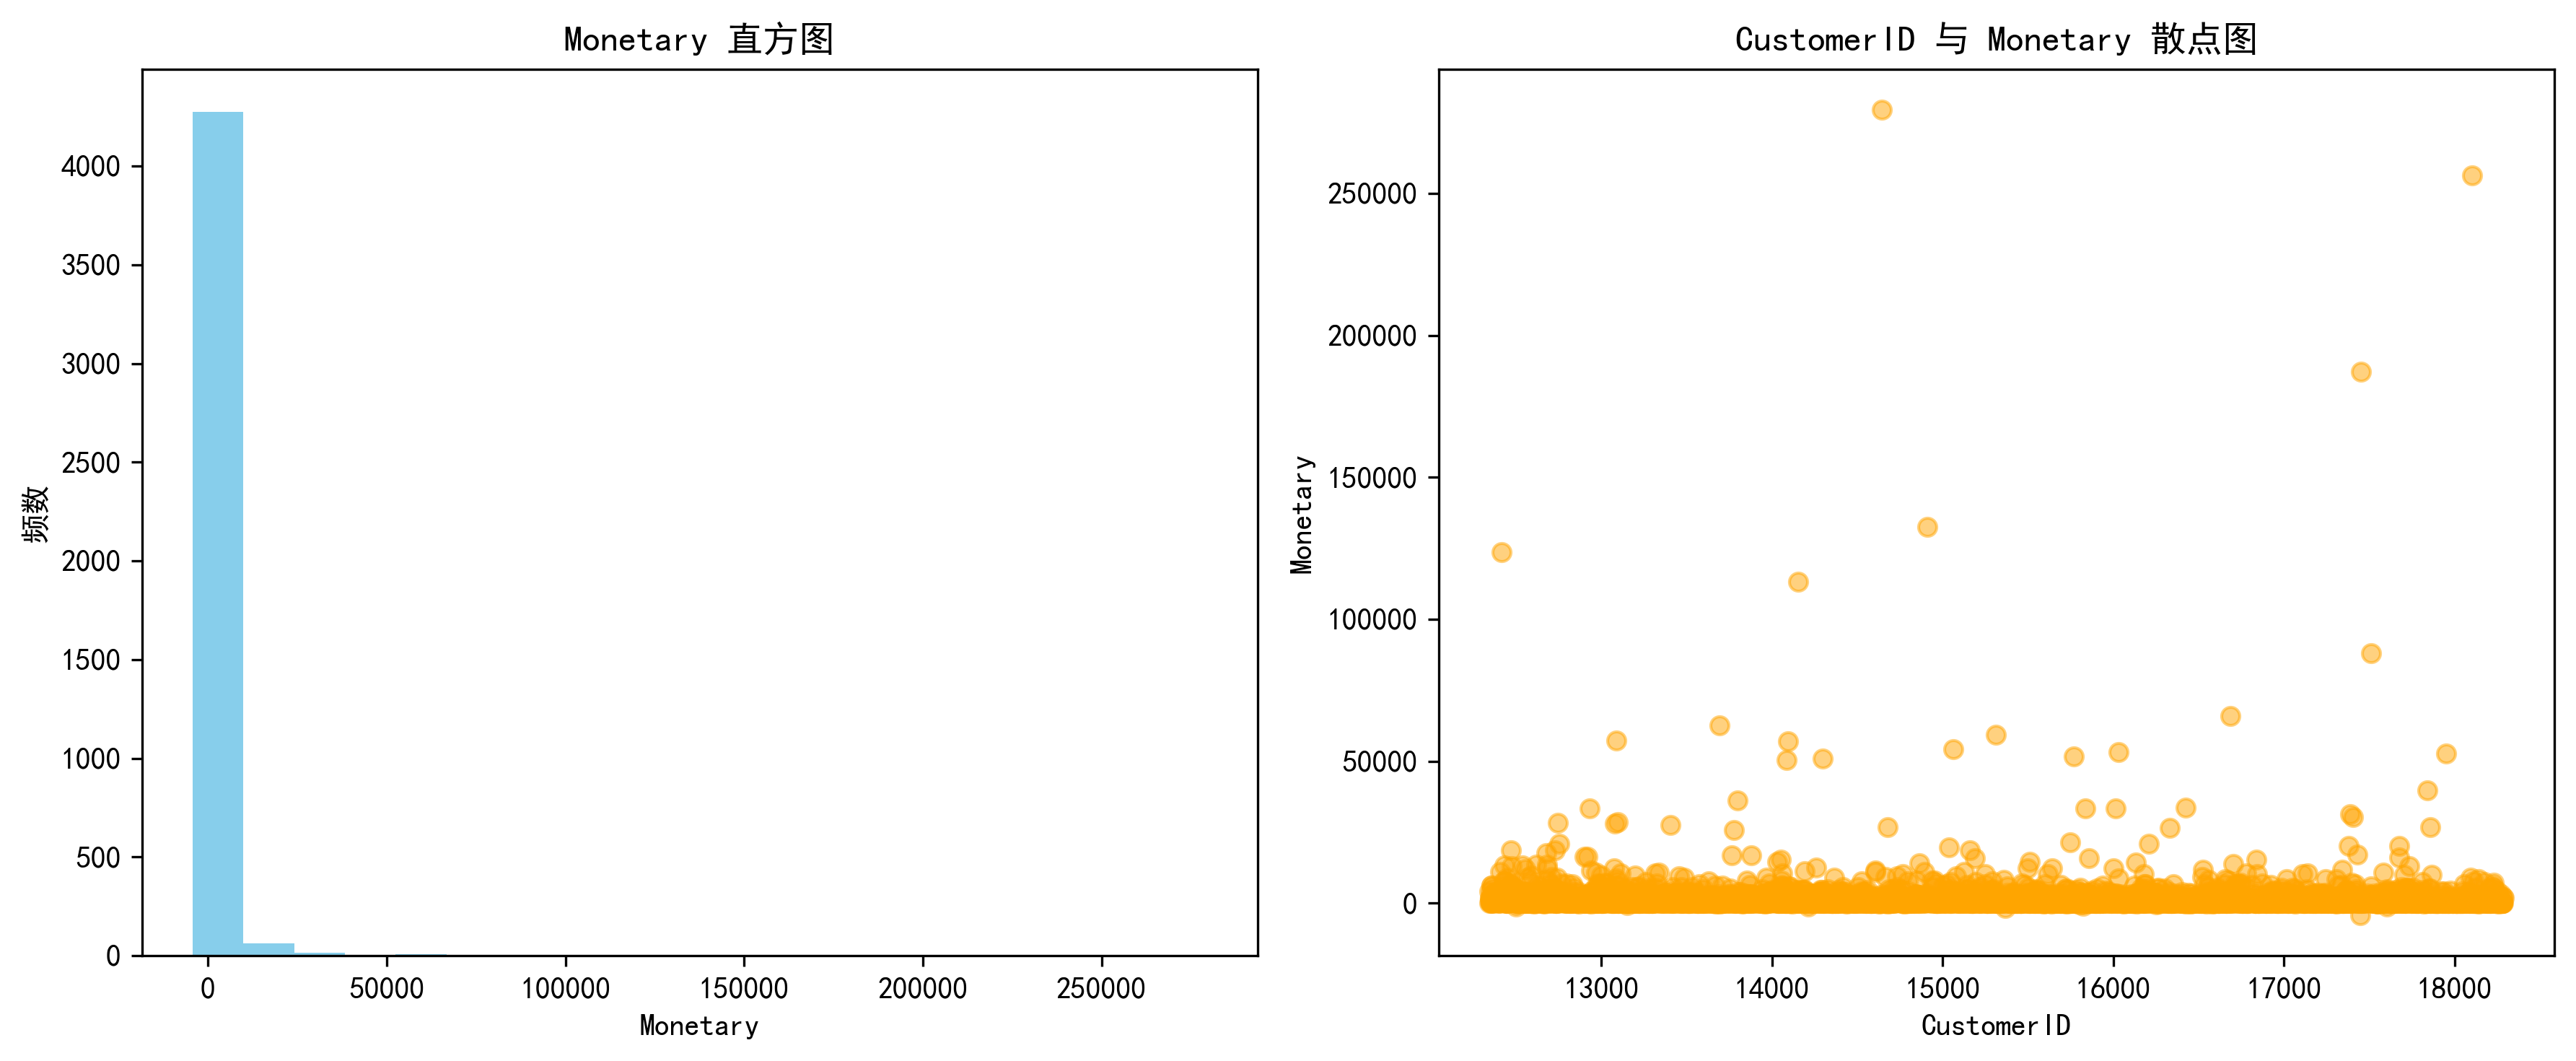

In [15]:
plt.rcParams['figure.dpi'] = 300
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

# 计算描述性统计信息，并保留两位小数
result = monetary[['CustomerID', 'Monetary']].describe().round(2)
print(result)

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 绘制 Monetary 的直方图
axes[0].hist(monetary['Monetary'], bins=20, color='skyblue')
axes[0].set_title('Monetary 直方图')
axes[0].set_xlabel('Monetary')
axes[0].set_ylabel('频数')

# 绘制 CustomerID 与 Monetary 的散点图
axes[1].scatter(monetary['CustomerID'], monetary['Monetary'], color='orange', alpha=0.5)
axes[1].set_title('CustomerID 与 Monetary 散点图')
axes[1].set_xlabel('CustomerID')
axes[1].set_ylabel('Monetary')

# 自动调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

## 计算R：使用2012/01/01 00:00的时间戳，减去每一顾客ID中最大的InvoiceDate

In [16]:
df = df[~(c_start_rows)]
group = df.groupby('CustomerID')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
def calculate_recency(group):
    td = pd.Timestamp('2012-01-01 00:00:00')
    tts = td.timestamp()
    md = group['InvoiceDate'].max()
    mts = md.timestamp()
    return tts - mts
recency = group.apply(calculate_recency).rename('Recency').reset_index()
recency

<ipython-input-16-ab0e1d774699>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


CustomerID     Recency
0        12346.0  30031140.0
1        12347.0   2102880.0
2        12348.0   8419620.0
3        12349.0   3506940.0
4        12350.0  28713540.0
...          ...         ...
4334     18280.0  25884480.0
4335     18281.0  17500020.0
4336     18282.0   2549820.0
4337     18283.0   2203080.0
4338     18287.0   5581860.0

[4339 rows x 2 columns]

In [17]:
recency.to_excel('recency.xlsx')

       CustomerID      Recency
count     4339.00      4339.00
mean     15299.94   9892504.22
std       1721.89   8640761.39
min      12346.00   1941000.00
25%      13812.50   3415770.00
50%      15299.00   6268380.00
75%      16778.50  14168400.00
max      18287.00  34178820.00


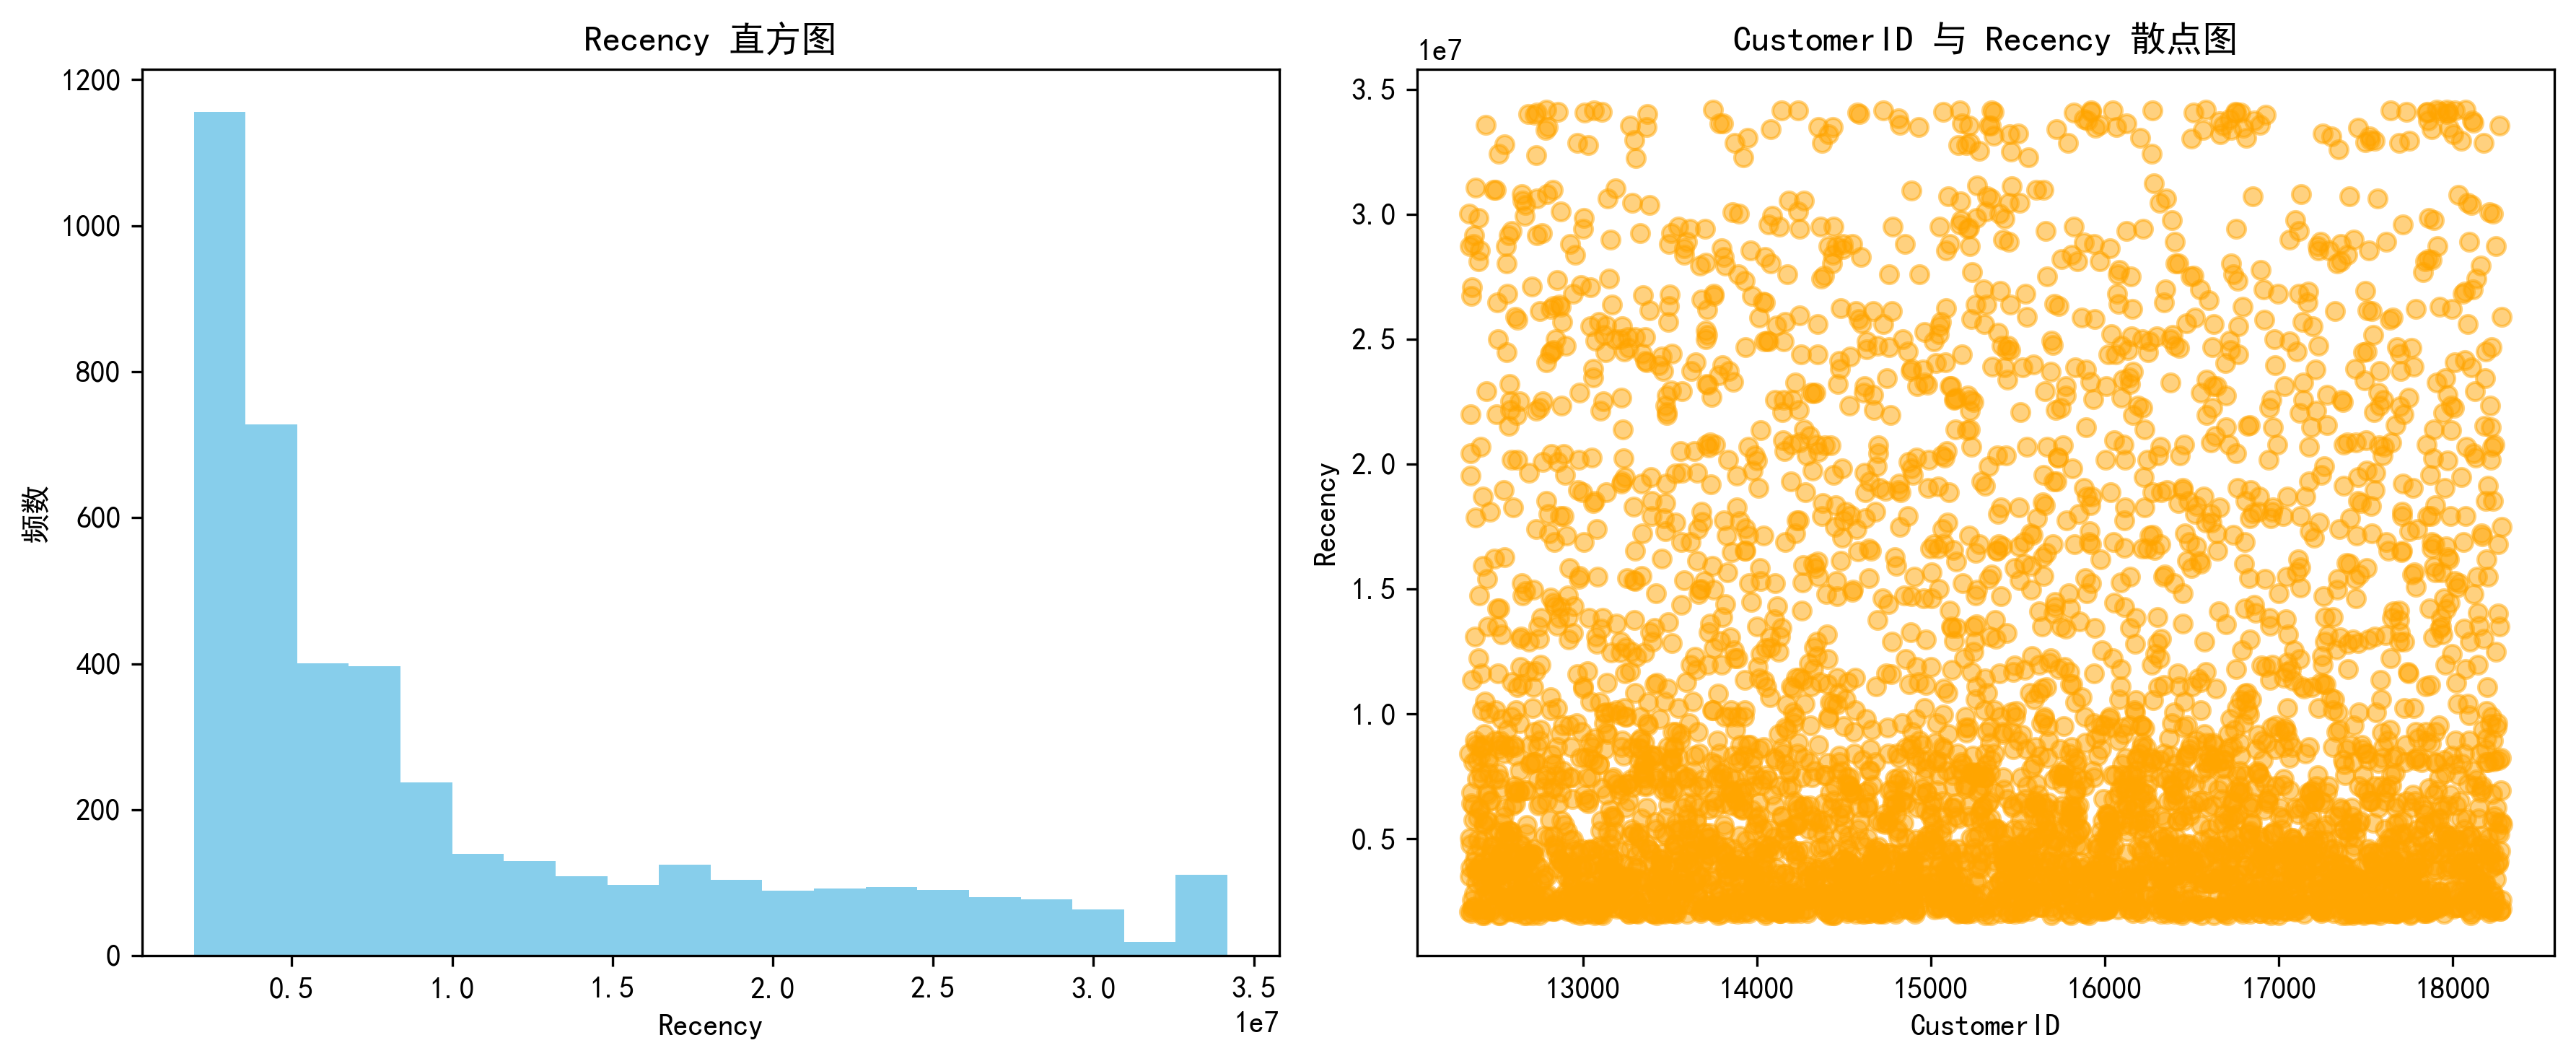

In [18]:
plt.rcParams['figure.dpi'] = 300

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

# 计算描述性统计信息，并保留两位小数
result = recency[['CustomerID', 'Recency']].describe().round(2)
print(result)

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 绘制 Monetary 的直方图
axes[0].hist(recency['Recency'], bins=20, color='skyblue')
axes[0].set_title('Recency 直方图')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('频数')

# 绘制 CustomerID 与 Monetary 的散点图
axes[1].scatter(recency['CustomerID'], recency['Recency'], color='orange', alpha=0.5)
axes[1].set_title('CustomerID 与 Recency 散点图')
axes[1].set_xlabel('CustomerID')
axes[1].set_ylabel('Recency')

# 自动调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

In [19]:
recency['Recency_Days'] = [x/86400 for x in recency['Recency']]

       CustomerID  Recency_Days
count     4339.00       4339.00
mean     15299.94        114.50
std       1721.89        100.01
min      12346.00         22.47
25%      13812.50         39.53
50%      15299.00         72.55
75%      16778.50        163.99
max      18287.00        395.59


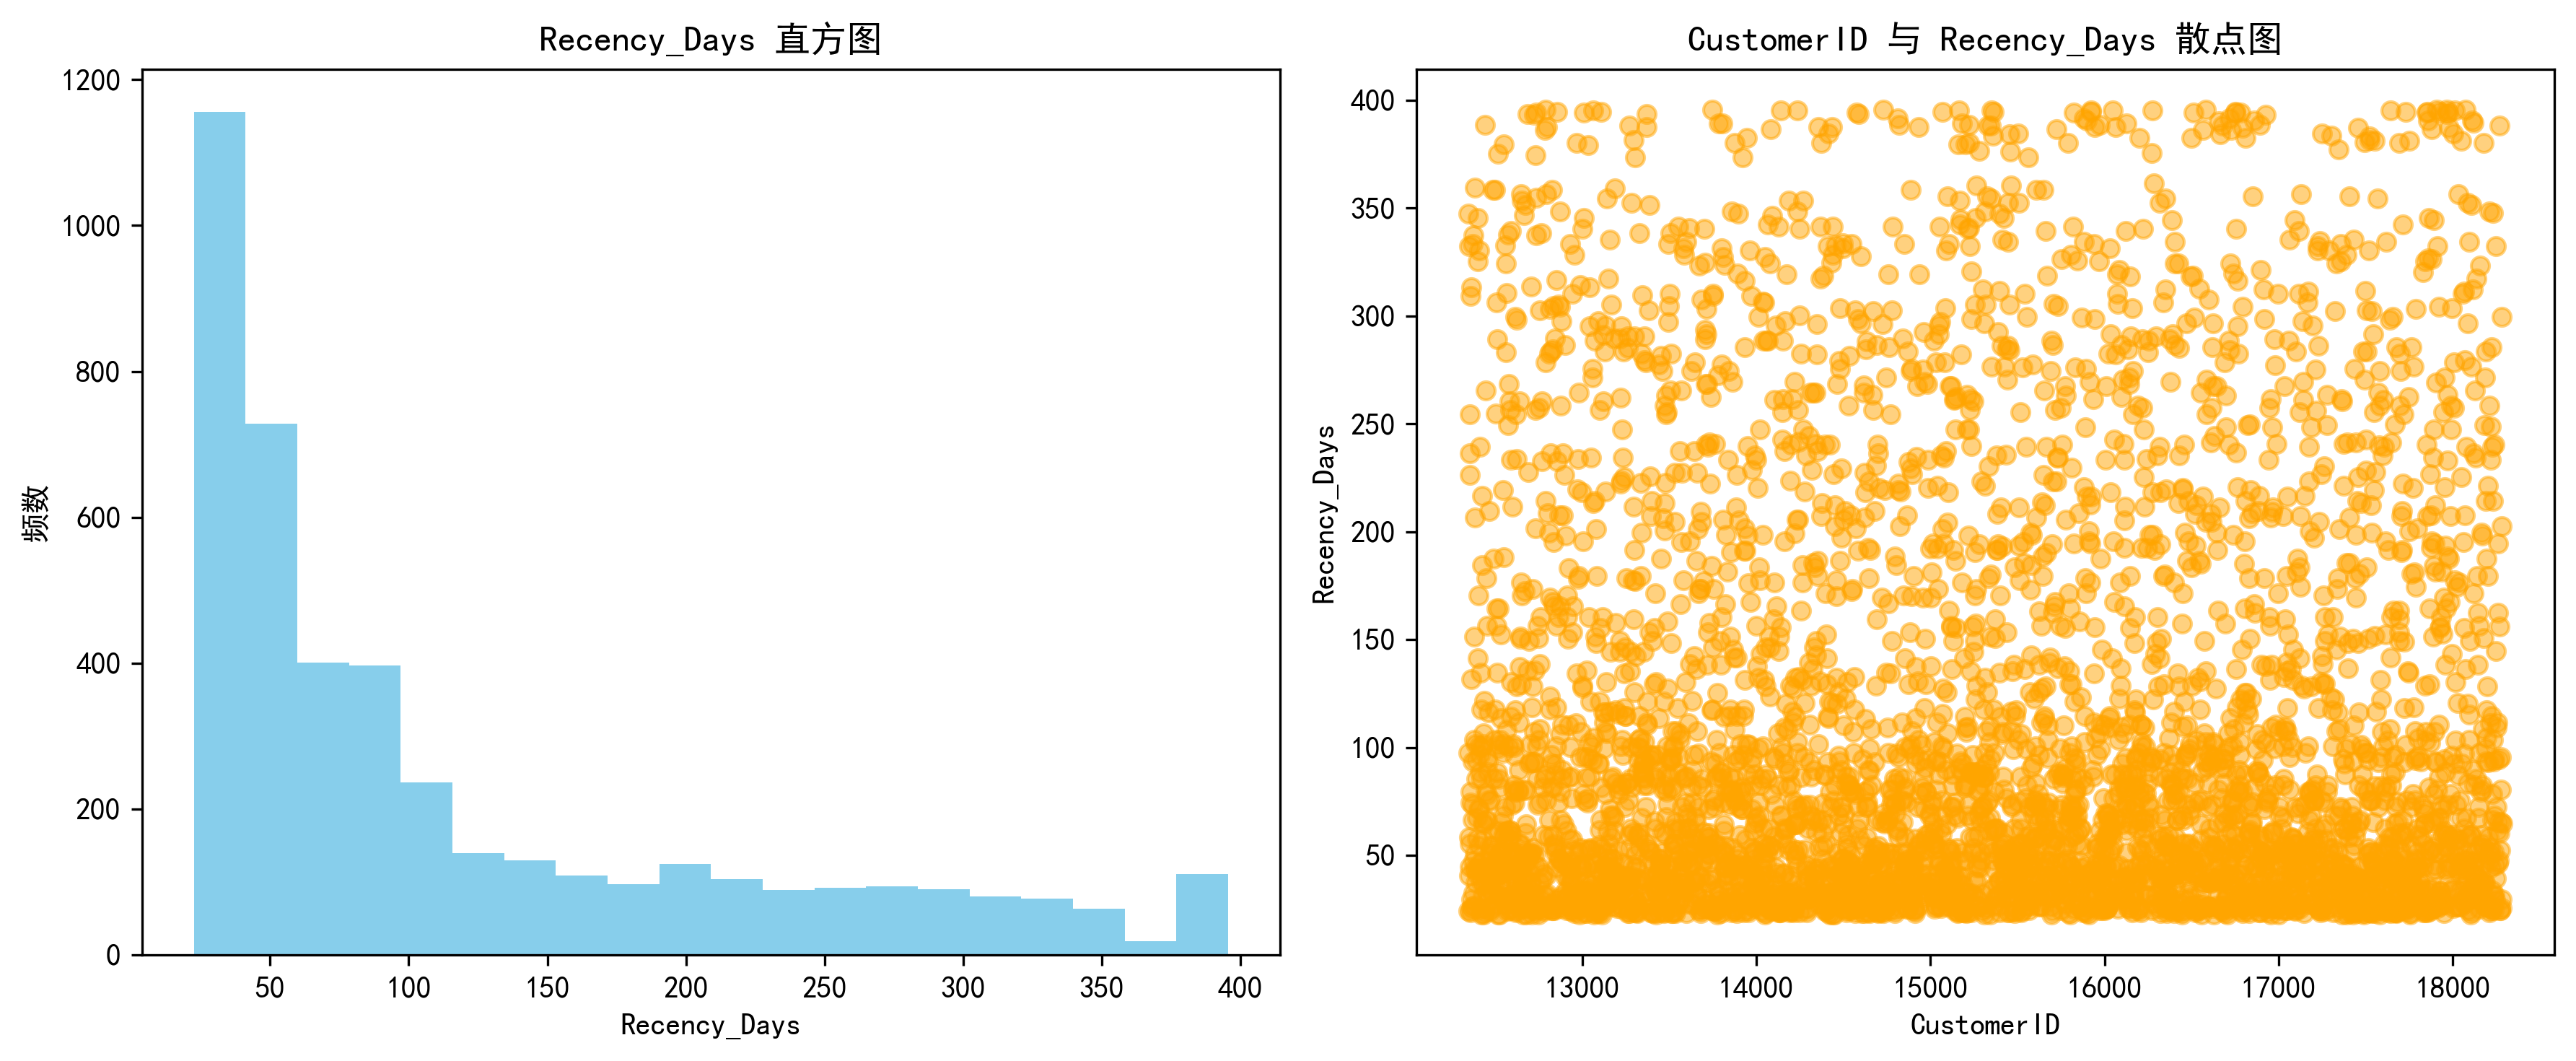

In [20]:
plt.rcParams['figure.dpi'] = 300

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

# 计算描述性统计信息，并保留两位小数
result = recency[['CustomerID', 'Recency_Days']].describe().round(2)
print(result)

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 绘制 Monetary 的直方图
axes[0].hist(recency['Recency_Days'], bins=20, color='skyblue')
axes[0].set_title('Recency_Days 直方图')
axes[0].set_xlabel('Recency_Days')
axes[0].set_ylabel('频数')

# 绘制 CustomerID 与 Monetary 的散点图
axes[1].scatter(recency['CustomerID'], recency['Recency_Days'], color='orange', alpha=0.5)
axes[1].set_title('CustomerID 与 Recency_Days 散点图')
axes[1].set_xlabel('CustomerID')
axes[1].set_ylabel('Recency_Days')

# 自动调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

## 计算F:根据分组结果，统计InvoiceNo的类别数以及总数

In [21]:
df = df[~(c_start_rows|related_rows)]
group = df.groupby('CustomerID')
frequency = group['InvoiceNo'].agg(['nunique', 'count']).rename(
    columns={'nunique': 'InvoiceNo_Category_Count', 'count': 'InvoiceNo_Total_Count'})
frequency = frequency.reset_index()
frequency

<ipython-input-21-913abd663689>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~(c_start_rows|related_rows)]


CustomerID  InvoiceNo_Category_Count  InvoiceNo_Total_Count
0        12346.0                         1                      1
1        12347.0                         7                    182
2        12348.0                         4                     31
3        12349.0                         1                     73
4        12350.0                         1                     17
...          ...                       ...                    ...
4334     18280.0                         1                     10
4335     18281.0                         1                      7
4336     18282.0                         2                     12
4337     18283.0                        16                    721
4338     18287.0                         3                     70

[4339 rows x 3 columns]

In [22]:
frequency.to_excel('frequency.xlsx')

       CustomerID  InvoiceNo_Category_Count  InvoiceNo_Total_Count
count     4339.00                   4339.00                4339.00
mean     15299.94                      4.27                  90.51
std       1721.89                      7.71                 225.52
min      12346.00                      1.00                   1.00
25%      13812.50                      1.00                  17.00
50%      15299.00                      2.00                  41.00
75%      16778.50                      5.00                  98.00
max      18287.00                    210.00                7676.00


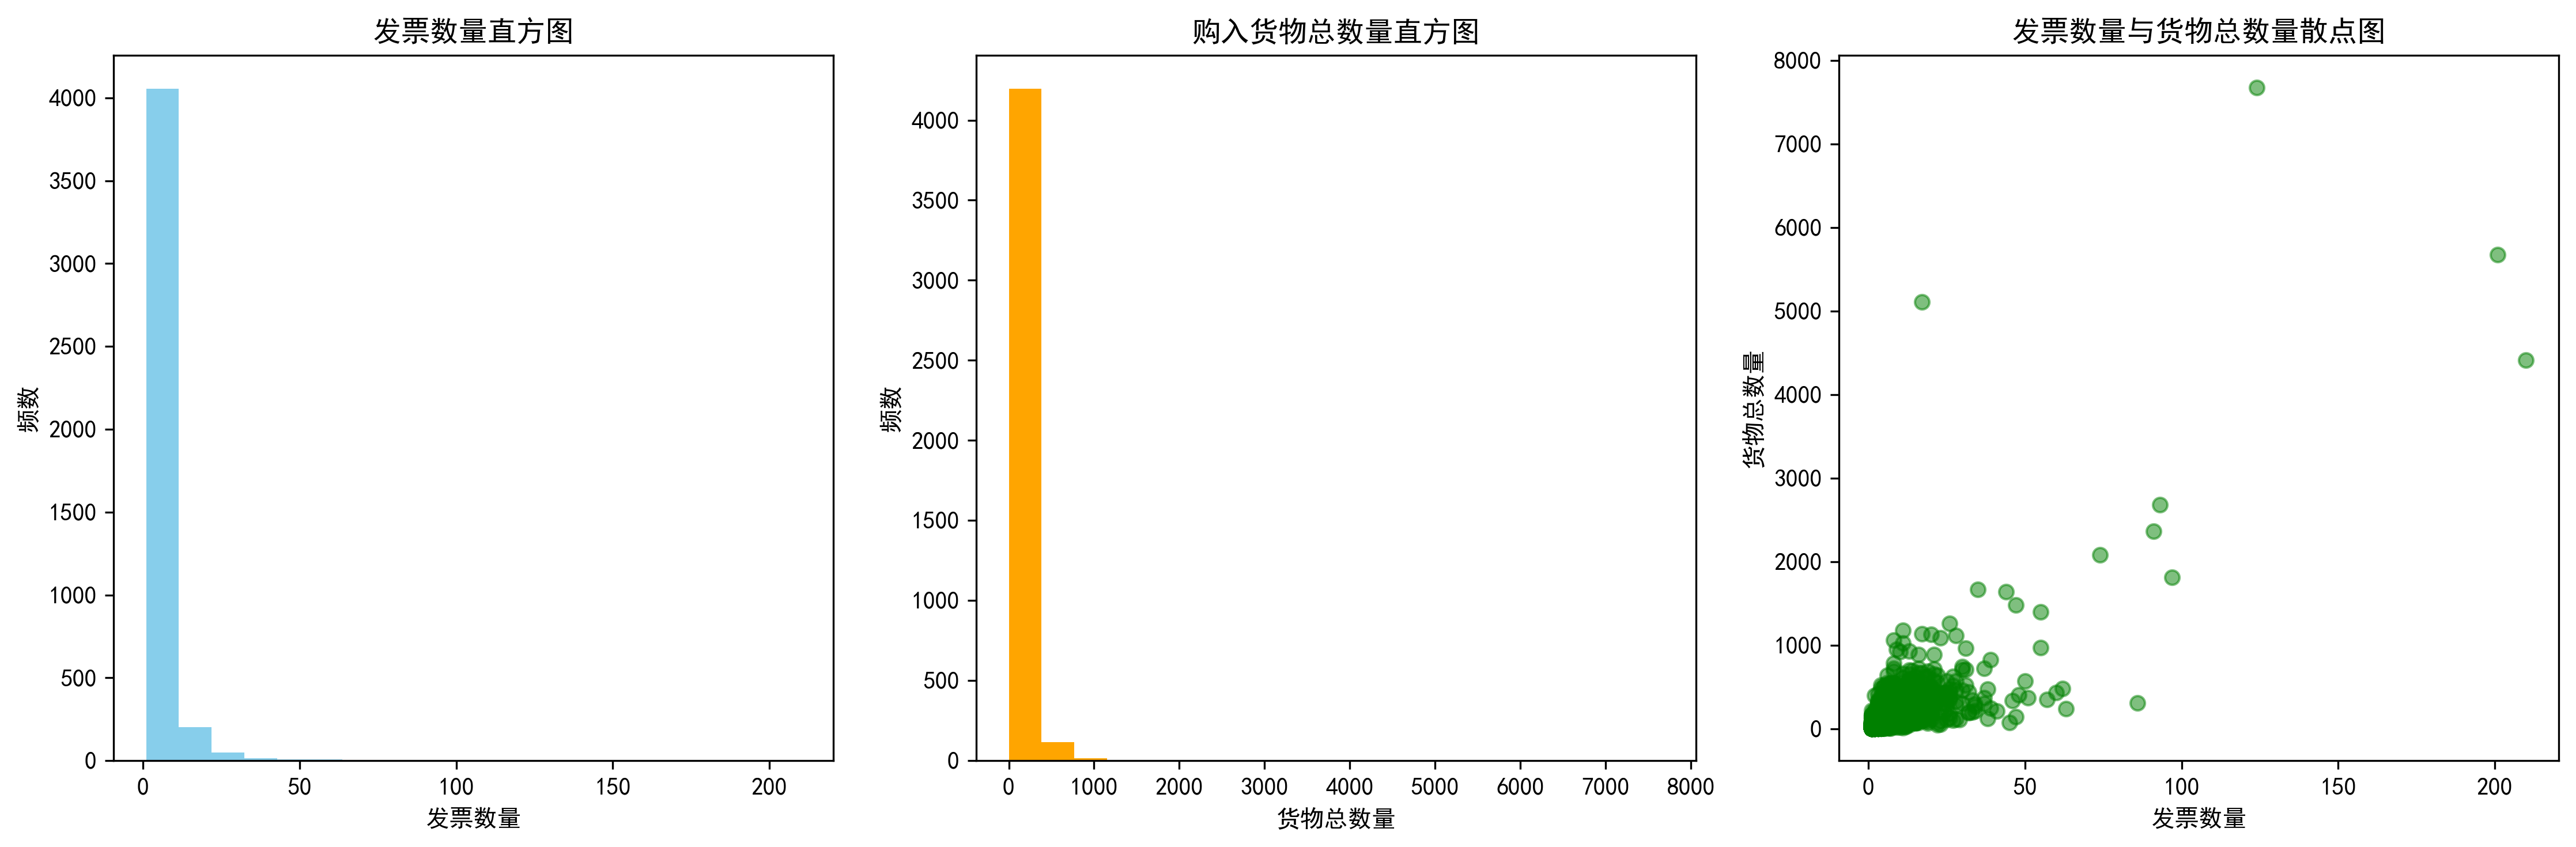

In [23]:
plt.rcParams['figure.dpi'] = 300
# 计算描述性统计信息，并保留两位小数
result = frequency[['CustomerID', 'InvoiceNo_Category_Count', 'InvoiceNo_Total_Count']].describe().round(2)
print(result)

# 创建一个 1 行 3 列的子图画布
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制 InvoiceNo_Category_Count 的直方图
axes[0].hist(frequency['InvoiceNo_Category_Count'], bins=20, color='skyblue')
axes[0].set_title('发票数量直方图')
axes[0].set_xlabel('发票数量')
axes[0].set_ylabel('频数')

# 绘制 InvoiceNo_Total_Count 的直方图
axes[1].hist(frequency['InvoiceNo_Total_Count'], bins=20, color='orange')
axes[1].set_title('购入货物总数量直方图')
axes[1].set_xlabel('货物总数量')
axes[1].set_ylabel('频数')

# 绘制 InvoiceNo_Category_Count 和 InvoiceNo_Total_Count 的散点图
axes[2].scatter(frequency['InvoiceNo_Category_Count'], frequency['InvoiceNo_Total_Count'], color='green', alpha=0.5)
axes[2].set_title('发票数量与货物总数量散点图')
axes[2].set_xlabel('发票数量')
axes[2].set_ylabel('货物总数量')

# 自动调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

In [24]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

In [25]:
rfm

CustomerID     Recency  Recency_Days  InvoiceNo_Category_Count  \
0        12346.0  30031140.0    347.582639                         1   
1        12347.0   2102880.0     24.338889                         7   
2        12348.0   8419620.0     97.449306                         4   
3        12349.0   3506940.0     40.589583                         1   
4        12350.0  28713540.0    332.332639                         1   
...          ...         ...           ...                       ...   
4334     18280.0  25884480.0    299.588889                         1   
4335     18281.0  17500020.0    202.546528                         1   
4336     18282.0   2549820.0     29.511806                         2   
4337     18283.0   2203080.0     25.498611                        16   
4338     18287.0   5581860.0     64.604861                         3   

      InvoiceNo_Total_Count  Monetary  
0                         1      0.00  
1                       182   4310.00  
2                        31   1797.24  
3                        73   1757.55  
4                        17    334.40  
...                     ...       ...  
4334                     10    180.60  
4335                      7     80.82  
4336                     12    176.60  
4337                    721   2045.53  
4338                     70   1837.28  

[4339 rows x 6 columns]

In [26]:
rfm.to_excel('./rfm_data.xlsx', index=False)

In [27]:
df = pd.read_excel('rfm_data.xlsx')

In [28]:
df

CustomerID   Recency  Recency_Days  InvoiceNo_Category_Count  \
0          12346  30031140    347.582639                         1   
1          12347   2102880     24.338889                         7   
2          12348   8419620     97.449306                         4   
3          12349   3506940     40.589583                         1   
4          12350  28713540    332.332639                         1   
...          ...       ...           ...                       ...   
4334       18280  25884480    299.588889                         1   
4335       18281  17500020    202.546528                         1   
4336       18282   2549820     29.511806                         2   
4337       18283   2203080     25.498611                        16   
4338       18287   5581860     64.604861                         3   

      InvoiceNo_Total_Count  Monetary  
0                         1      0.00  
1                       182   4310.00  
2                        31   1797.24  
3                        73   1757.55  
4                        17    334.40  
...                     ...       ...  
4334                     10    180.60  
4335                      7     80.82  
4336                     12    176.60  
4337                    721   2045.53  
4338                     70   1837.28  

[4339 rows x 6 columns]

描述性统计信息：
           Recency  InvoiceNo_Category_Count   Monetary
count      4339.00                   4339.00    4339.00
mean    9892504.22                      4.27    1910.33
std     8640761.39                      7.71    8247.34
min     1941000.00                      1.00   -1165.30
25%     3415770.00                      1.00     297.98
50%     6268380.00                      2.00     649.50
75%    14168400.00                      5.00    1619.68
max    34178820.00                    210.00  279489.02


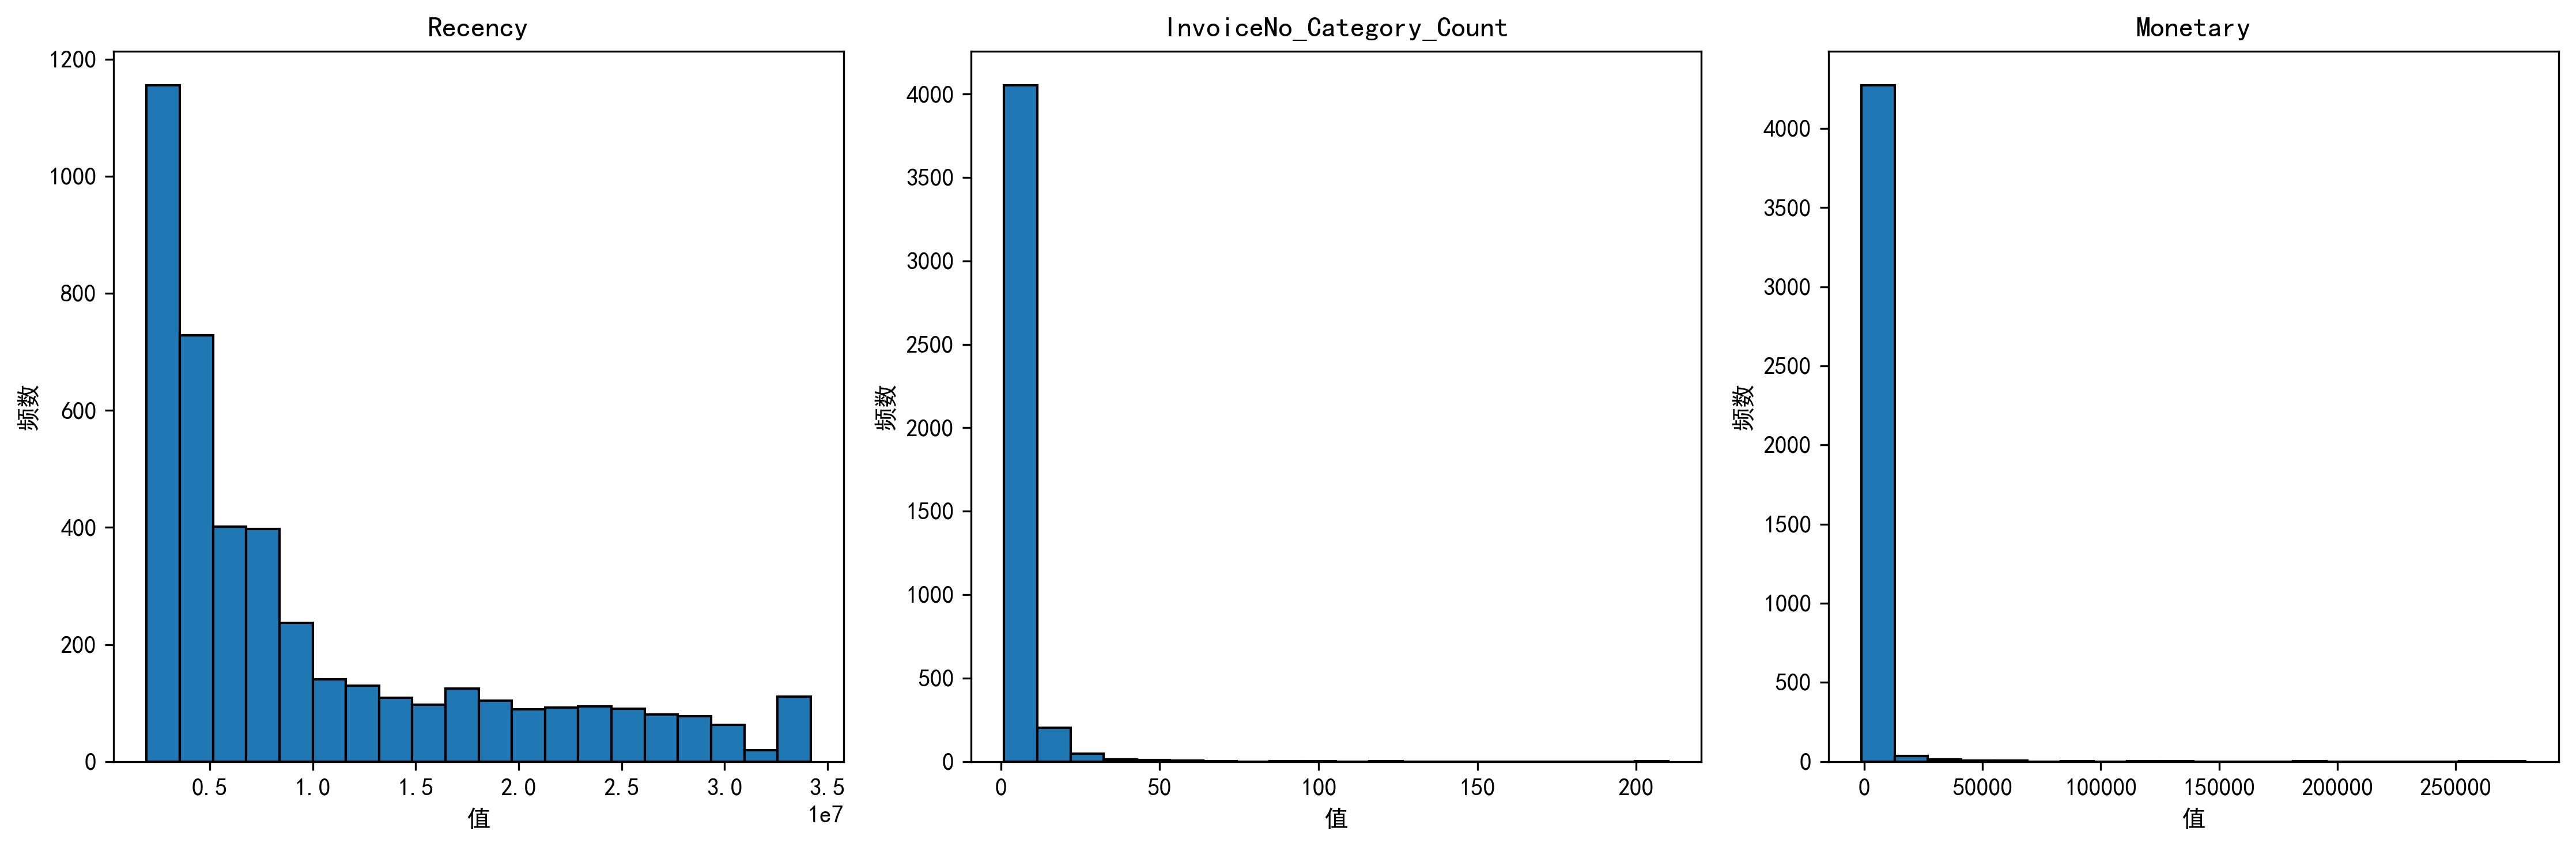

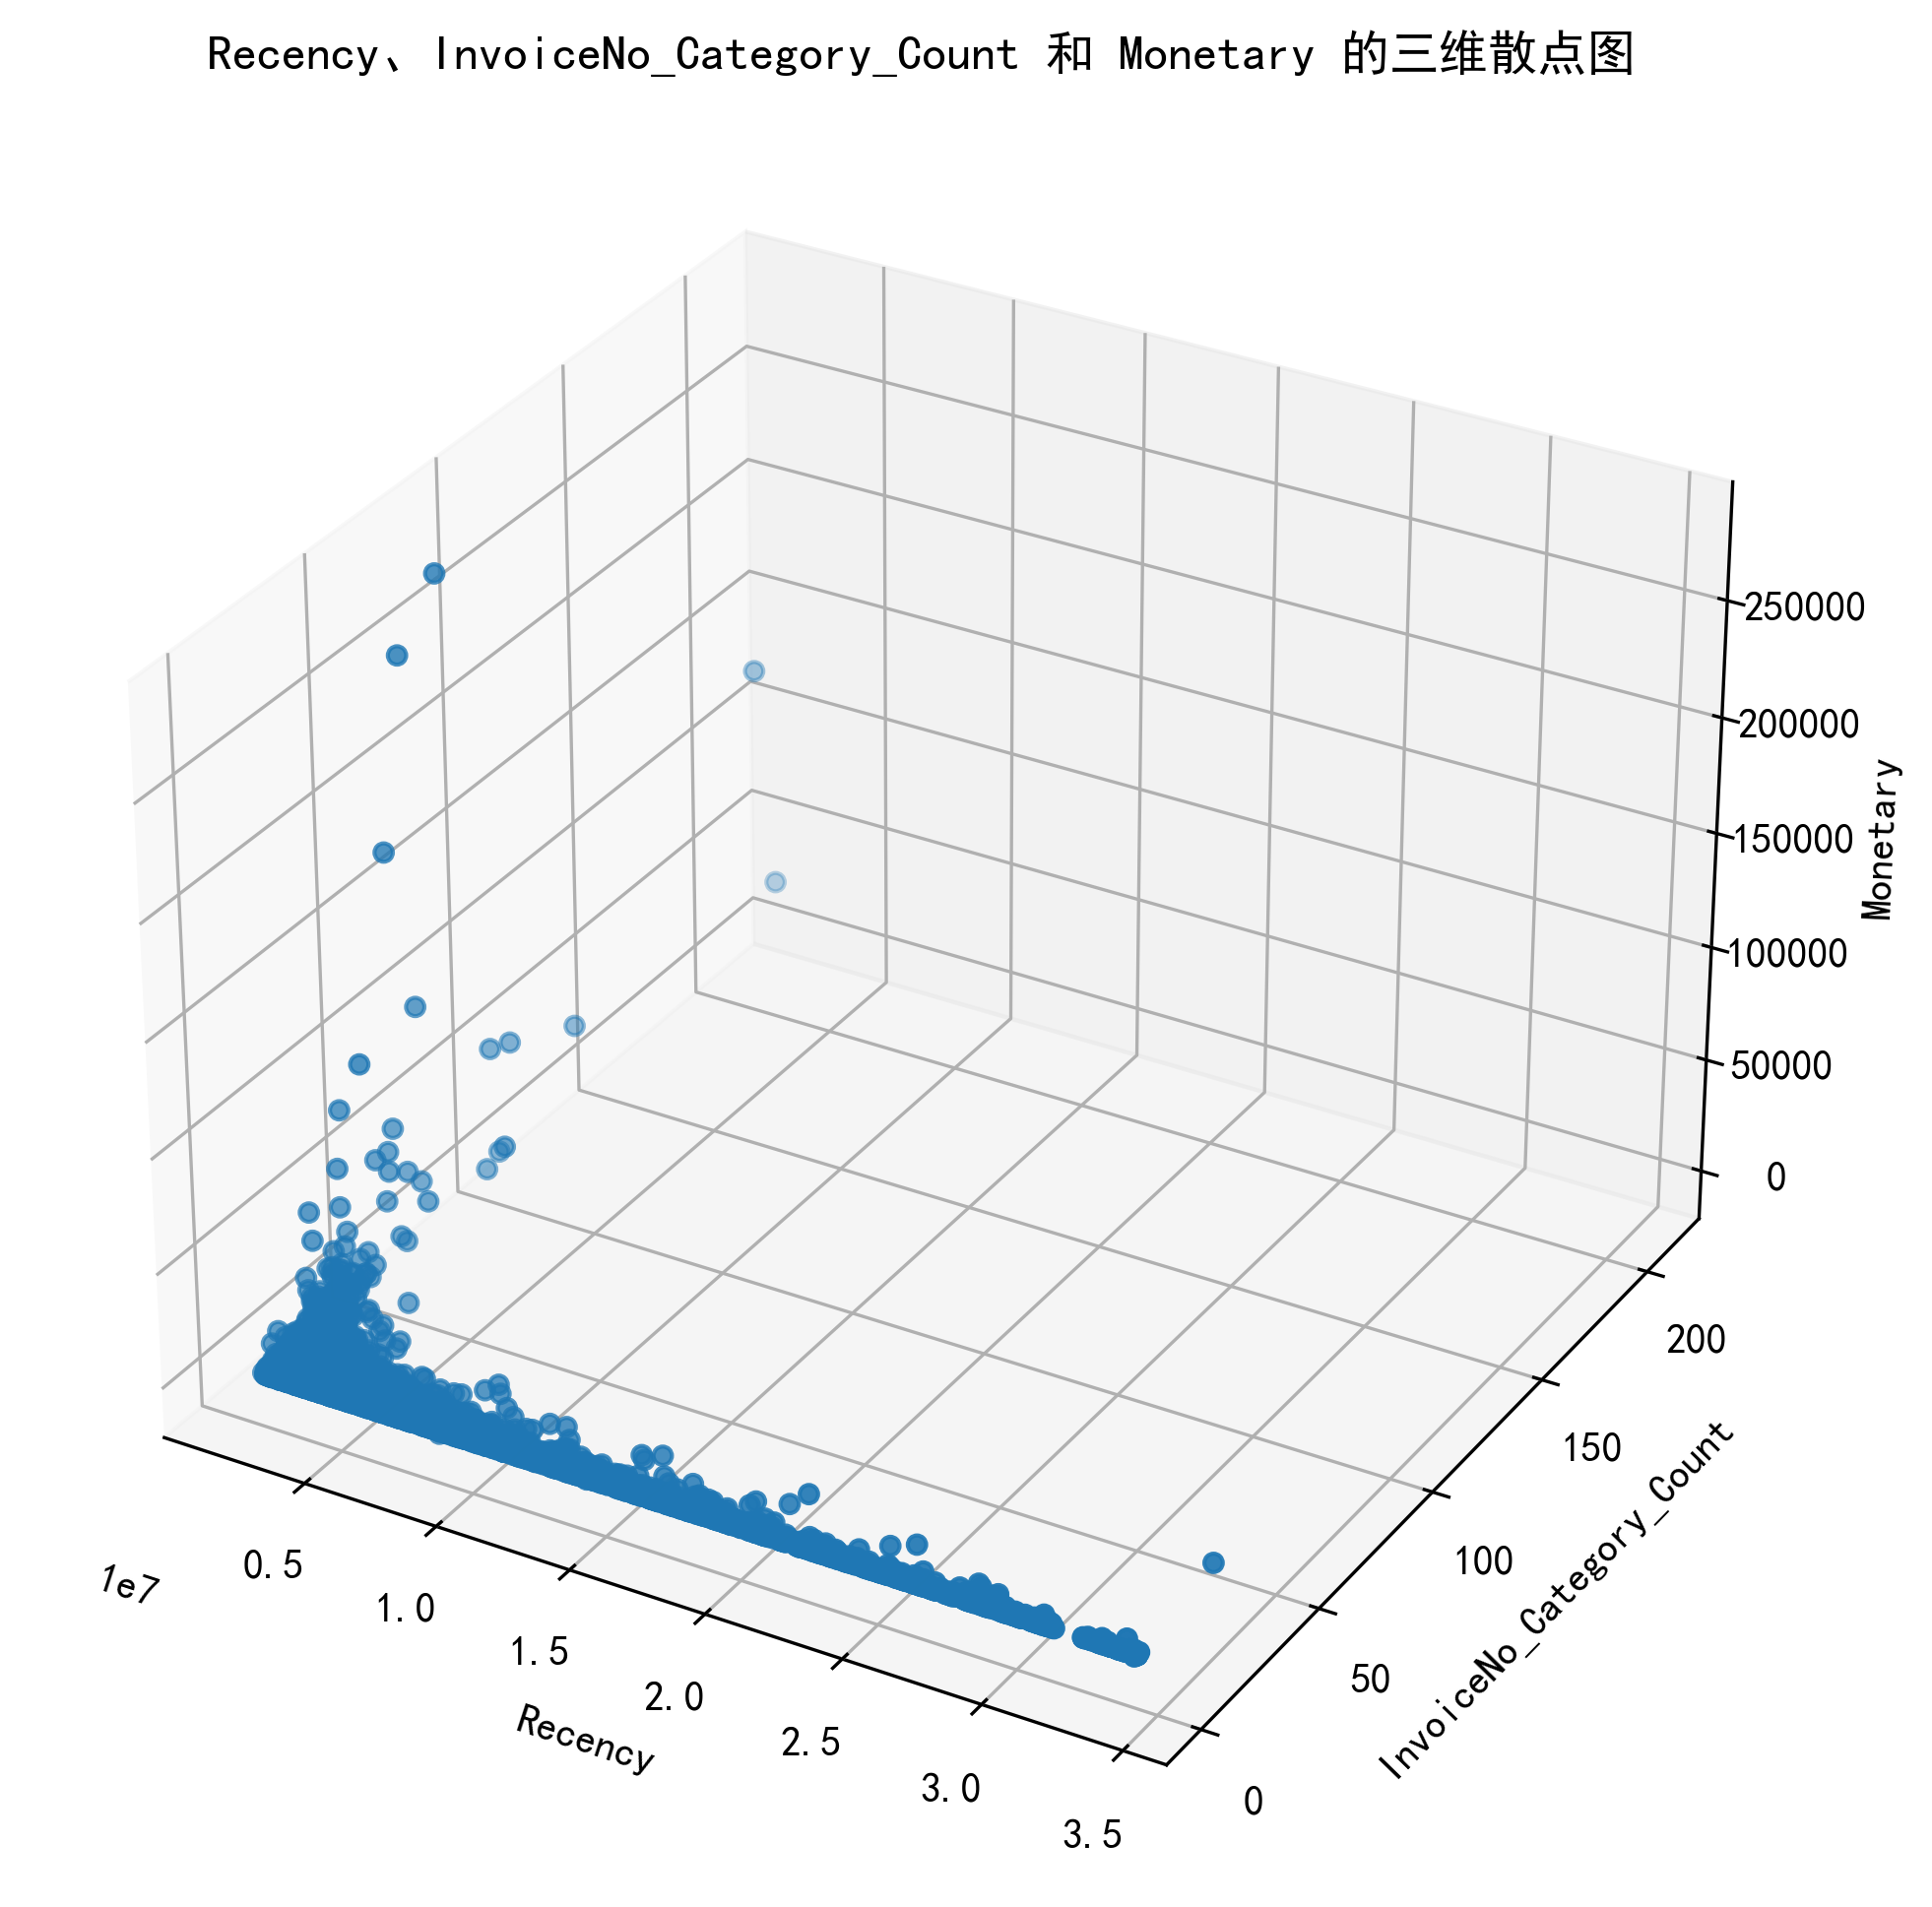

In [29]:
# 选择需要分析的列
columns = ['Recency', 'InvoiceNo_Category_Count', 'Monetary']
# 计算描述性统计信息，保留两位小数
result = df[columns].describe().round(2)
print('描述性统计信息：')
print(result)
# 创建一个包含 3 个子图的画布
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制直方图
for i, col in enumerate(columns):
    axes[i].hist(df[col], bins=20, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('值')
    axes[i].set_ylabel('频数')

plt.tight_layout()
plt.show()

# 创建一个新的画布用于绘制三维散点图
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
ax.scatter(df['Recency'], df['InvoiceNo_Category_Count'], df['Monetary'])

# 设置坐标轴标签和标题
ax.set_xlabel('Recency')
ax.set_ylabel('InvoiceNo_Category_Count')
ax.set_zlabel('Monetary')
ax.set_title('Recency、InvoiceNo_Category_Count 和 Monetary 的三维散点图')

plt.show()

In [31]:
low_value_rows = df[(df['InvoiceNo_Category_Count'] == 0) | (df['InvoiceNo_Total_Count'] == 0) | (df['Recency'] == 0) | (df['Monetary'] <= 0)]
print(low_value_rows)

      CustomerID   Recency  Recency_Days  InvoiceNo_Category_Count  \
0          12346  30031140    347.582639                         1   
89         12454   6763620     78.282639                         1   
685        13256   3139380     36.335417                         1   
984        13672  27943620    323.421528                         2   
1532       14437  33489180    387.606250                         1   
1630       14557   9274320    107.341667                         1   
1794       14792   7396860     85.611806                         1   
2541       15802  14214120    164.515278                         1   
2559       15823  34073520    394.369444                         1   
3015       16454   5746800     66.513889                         2   
3079       16546  27002400    312.527778                         2   
3220       16742   5918280     68.498611                         1   
3324       16878   9181260    106.264583                         1   
3799       17548  22

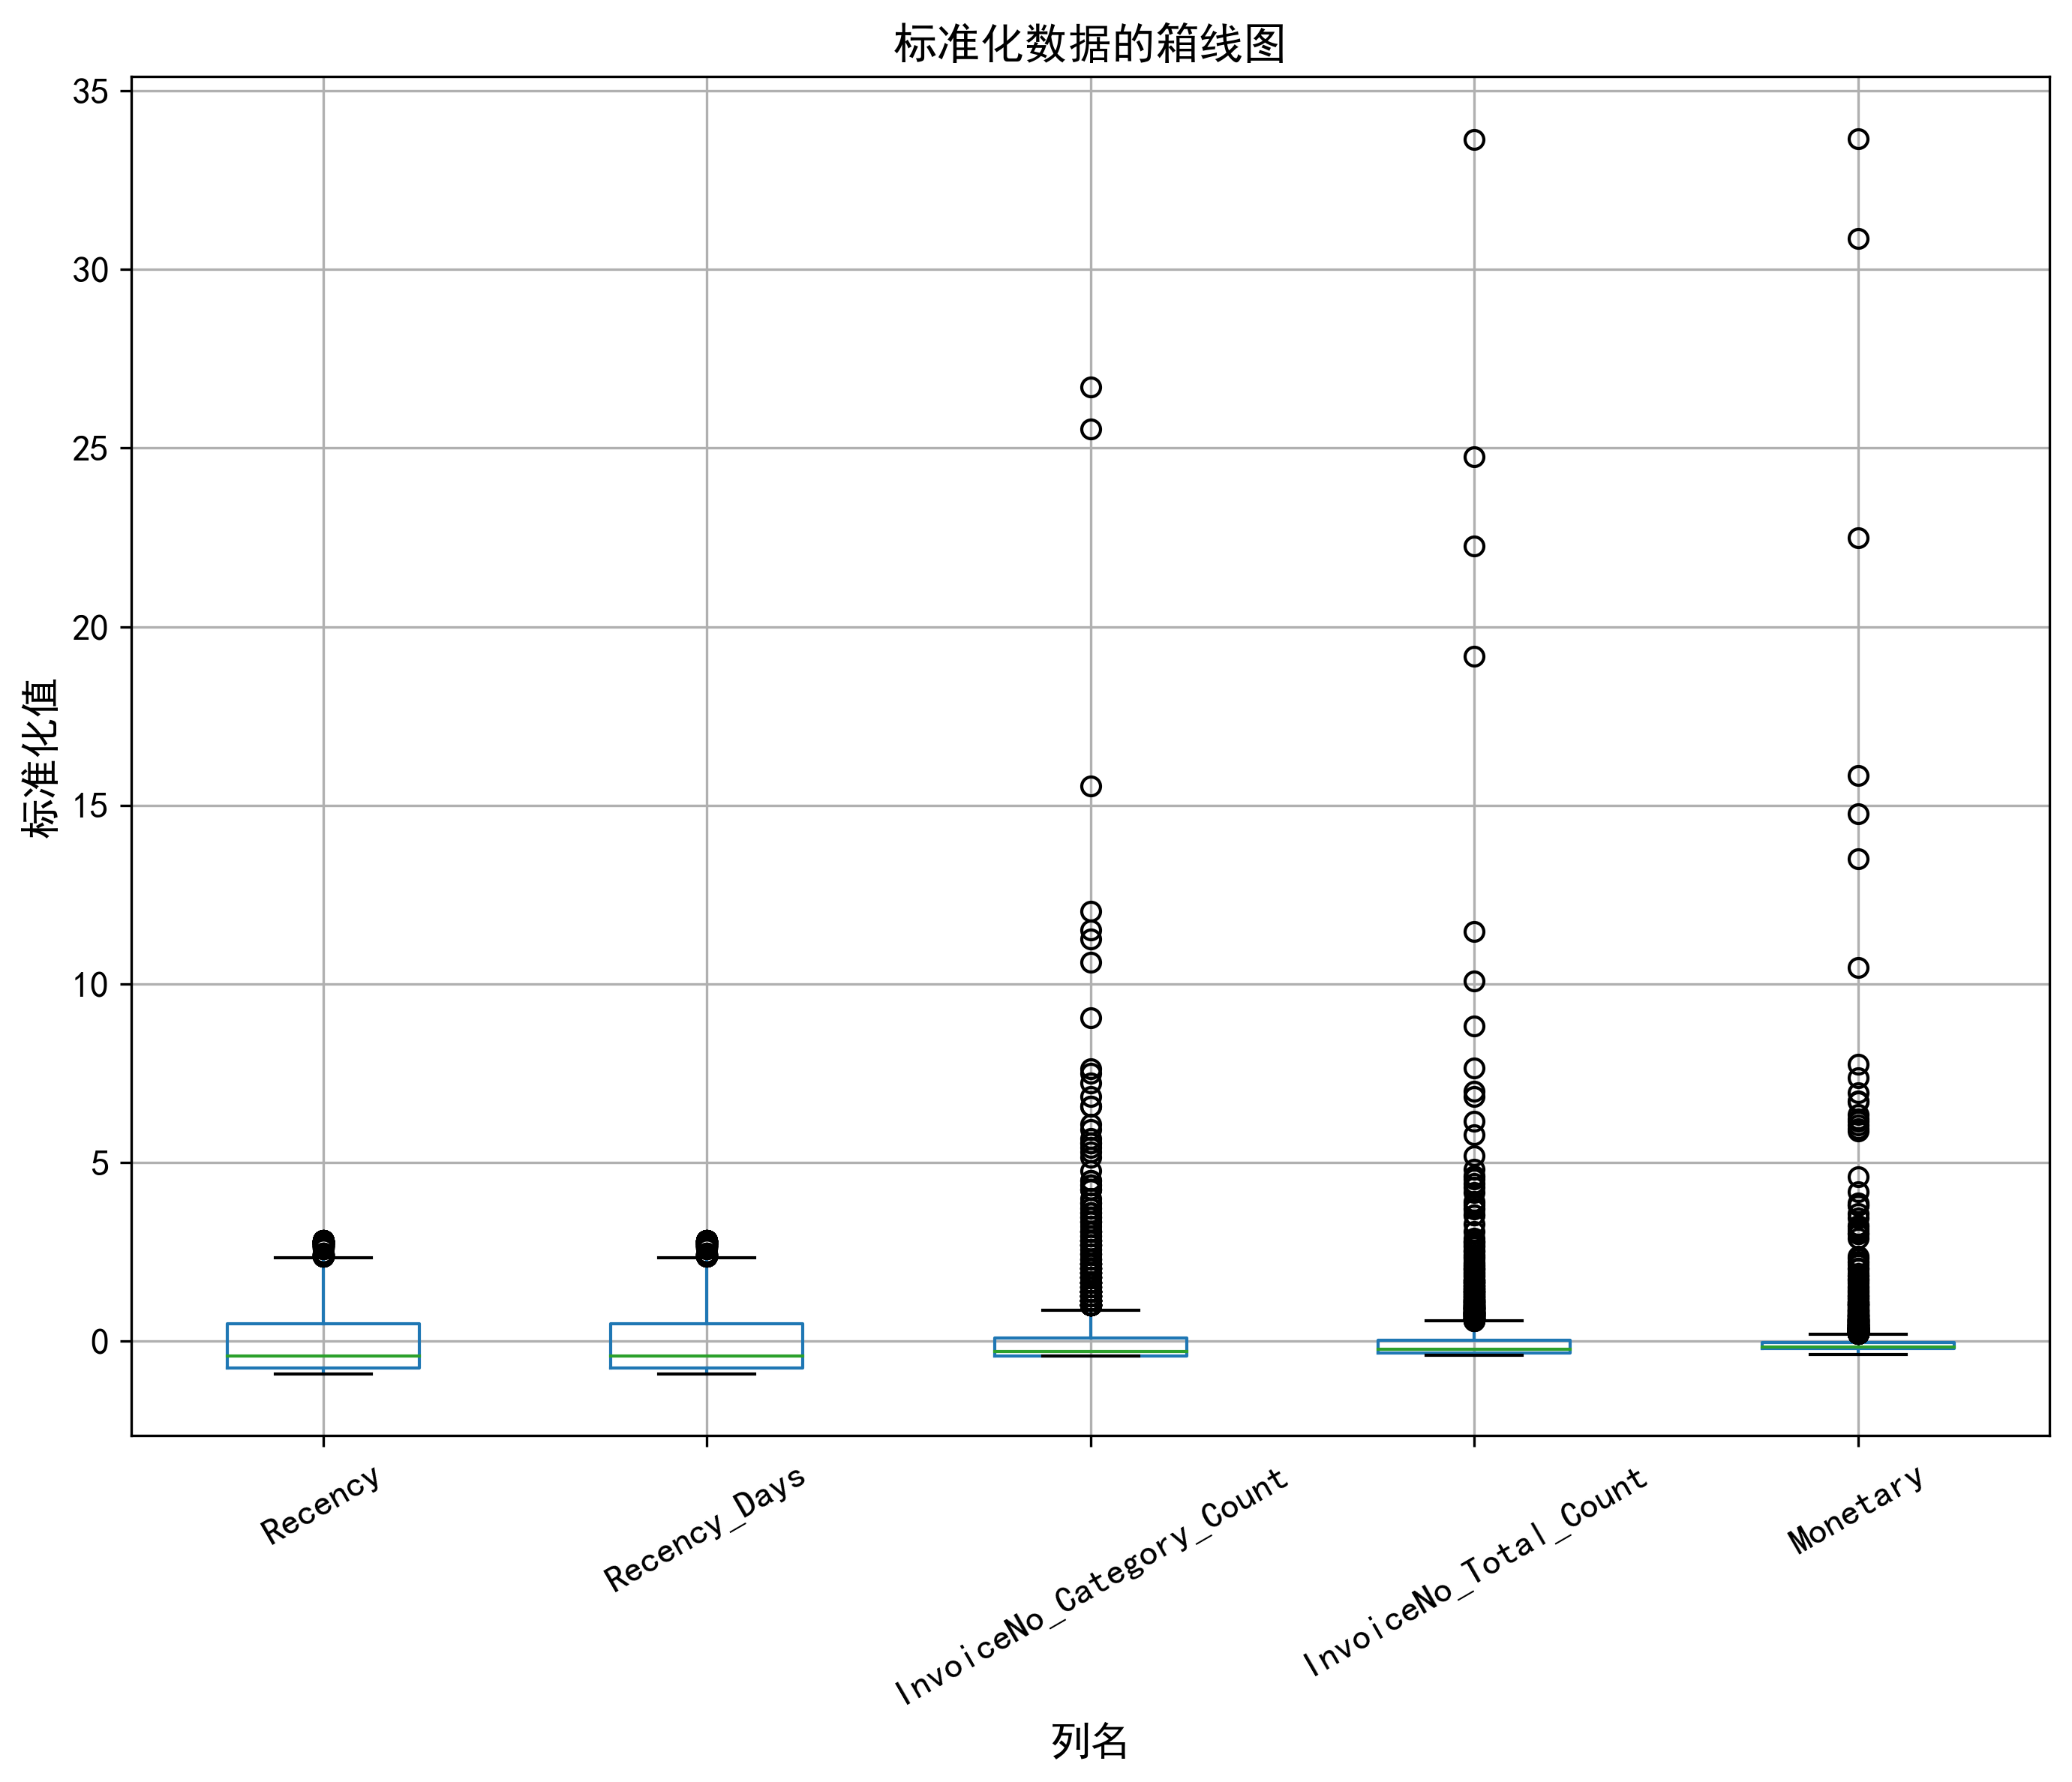

包含离群值的行：
      CustomerID   Recency  Recency_Days  InvoiceNo_Category_Count  \
1          12347   2102880     24.338889                         7   
10         12357   4780380     55.328472                         1   
12         12359   6865980     79.467361                         4   
15         12362   2190000     25.347222                        10   
27         12378  13094760    151.559722                         1   
...          ...       ...           ...                       ...   
4298       18229   2902320     33.591667                        20   
4308       18241   2721000     31.493056                        17   
4315       18251   9449820    109.372917                         1   
4326       18269  33559620    388.421528                         1   
4337       18283   2203080     25.498611                        16   

      InvoiceNo_Total_Count  Monetary  
1                       182   4310.00  
10                      131   6207.67  
12                      245   

In [32]:
# 提取需要标准化的列
columns_to_standardize = ['Recency', 'Recency_Days', 'InvoiceNo_Category_Count', 'InvoiceNo_Total_Count', 'Monetary']
data_to_standardize = df[columns_to_standardize]

# 标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_standardize)

# 将标准化后的数据转换回 DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_standardize)

# 设置字体大小
plt.rcParams.update({'font.size': 12})

# 绘制箱线图检测离群值
scaled_df.boxplot(figsize=(11,8))
plt.title('标准化数据的箱线图', fontsize=14)
plt.ylabel('标准化值', fontsize=13)
plt.xlabel('列名', fontsize=13)
plt.xticks(rotation=30)

plt.show()

# 查看是否存在离群值（以四分位距法为例）
Q1 = scaled_df.quantile(0.25)
Q3 = scaled_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((scaled_df < (Q1 - 1.5 * IQR)) | (scaled_df > (Q3 + 1.5 * IQR)))

# 找出包含离群值的行
outlier_rows = df[outliers.any(axis=1)]

print('包含离群值的行：')
print(outlier_rows)

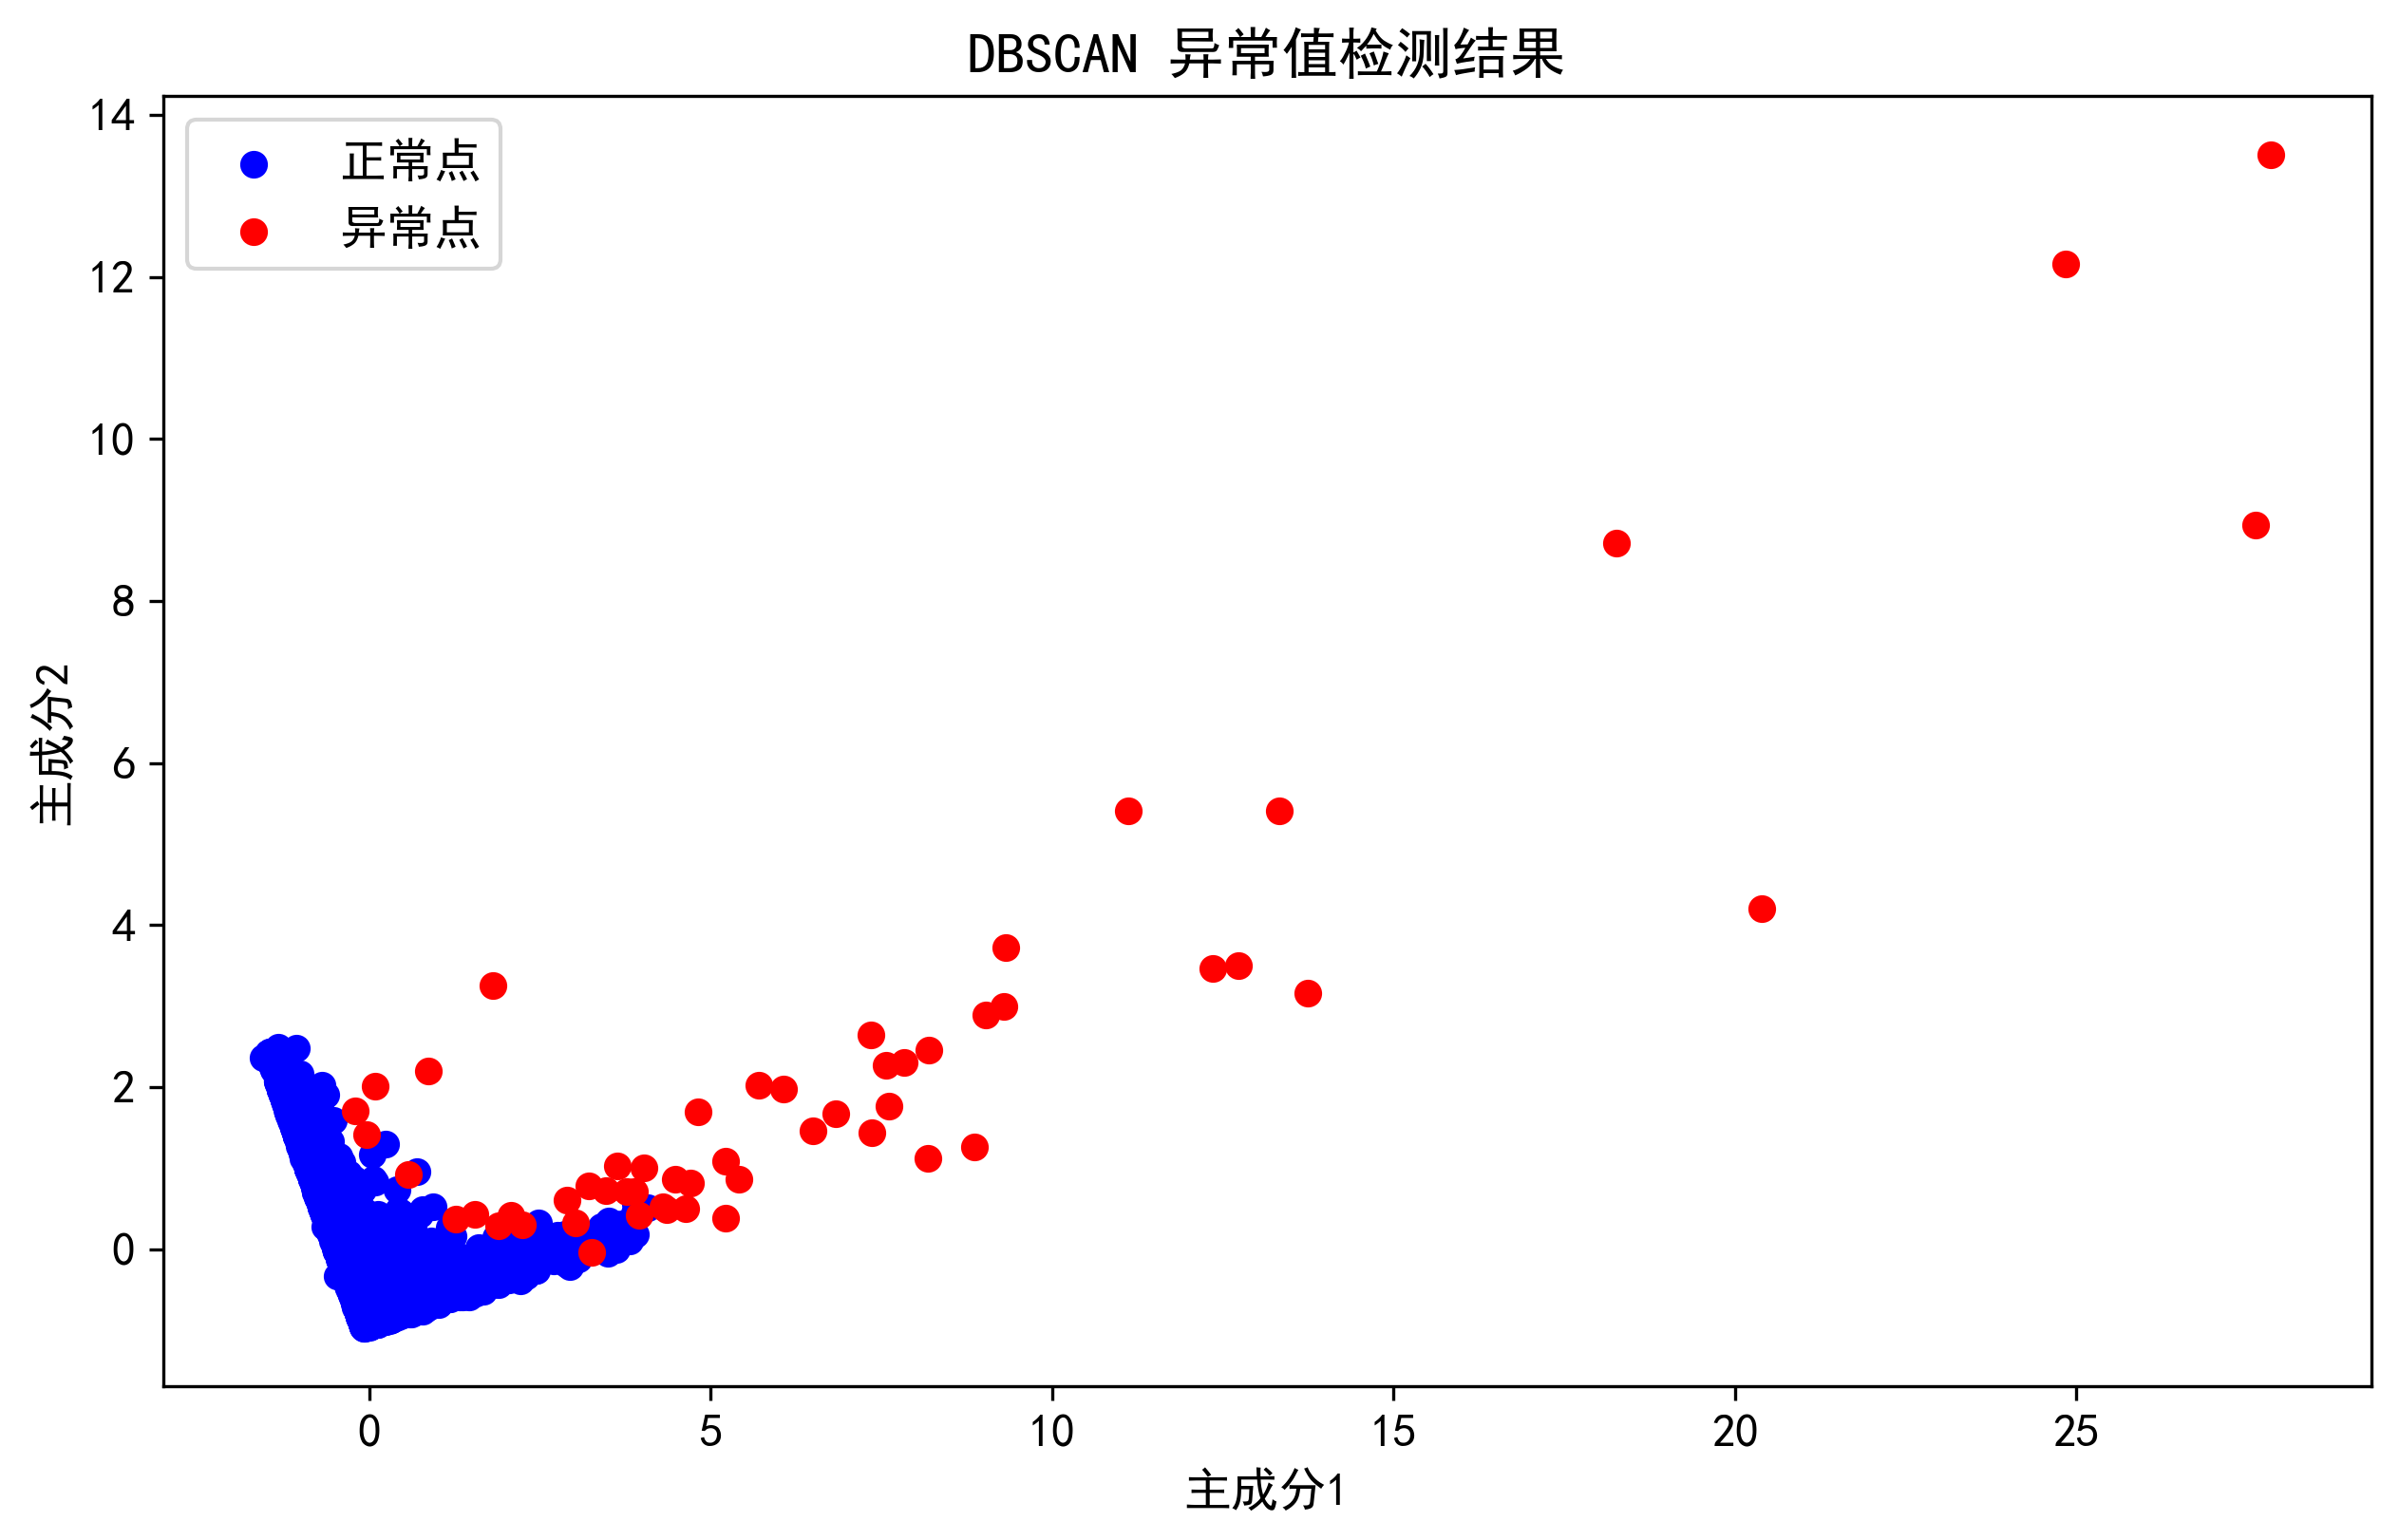

包含异常值的行：
      CustomerID   Recency  Recency_Days  InvoiceNo_Category_Count  \
55         12415   4009080     46.401389                        21   
196        12590  20164080    233.380556                         2   
269        12678   5568960     64.455556                        12   
314        12731   3931260     45.500694                        12   
326        12748   1942800     22.486111                       210   
330        12753   3848880     44.547222                         6   
445        12921   2705880     31.318056                        37   
453        12931   3756060     43.472917                        15   
481        12971   2202000     25.486111                        86   
485        12980  15517560    179.601389                         9   
558        13081   2898360     33.545833                        11   
562        13089   2127480     24.623611                        97   
566        13093  25703160    297.490278                         8   
570        

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# 提取需要分析的列
data = df[['Recency_Days', 'InvoiceNo_Category_Count', 'Monetary']]

# 数据标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 使用 DBSCAN 检测异常值
# eps 和 min_samples 需要根据数据特点调整
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(scaled_data)

# 标记异常值（标签为 -1 的是异常值）
is_outlier = labels == -1

# 使用 PCA 进行降维以便可视化（将三维数据降到二维）
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[~is_outlier, 0], reduced_data[~is_outlier, 1], c='b', label='正常点')
plt.scatter(reduced_data[is_outlier, 0], reduced_data[is_outlier, 1], c='r', label='异常点')
plt.title('DBSCAN 异常值检测结果')
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.legend()
plt.show()

# 输出包含异常值的行
outlier_rows = df[is_outlier]
print('包含异常值的行：')
print(outlier_rows)
print(len(outlier_rows))

In [34]:
rfm

CustomerID     Recency  Recency_Days  InvoiceNo_Category_Count  \
0        12346.0  30031140.0    347.582639                         1   
1        12347.0   2102880.0     24.338889                         7   
2        12348.0   8419620.0     97.449306                         4   
3        12349.0   3506940.0     40.589583                         1   
4        12350.0  28713540.0    332.332639                         1   
...          ...         ...           ...                       ...   
4334     18280.0  25884480.0    299.588889                         1   
4335     18281.0  17500020.0    202.546528                         1   
4336     18282.0   2549820.0     29.511806                         2   
4337     18283.0   2203080.0     25.498611                        16   
4338     18287.0   5581860.0     64.604861                         3   

      InvoiceNo_Total_Count  Monetary  
0                         1      0.00  
1                       182   4310.00  
2                        31   1797.24  
3                        73   1757.55  
4                        17    334.40  
...                     ...       ...  
4334                     10    180.60  
4335                      7     80.82  
4336                     12    176.60  
4337                    721   2045.53  
4338                     70   1837.28  

[4339 rows x 6 columns]

In [35]:
clean_df = df[~is_outlier]
clean_df

CustomerID   Recency  Recency_Days  InvoiceNo_Category_Count  \
0          12346  30031140    347.582639                         1   
1          12347   2102880     24.338889                         7   
2          12348   8419620     97.449306                         4   
3          12349   3506940     40.589583                         1   
4          12350  28713540    332.332639                         1   
...          ...       ...           ...                       ...   
4334       18280  25884480    299.588889                         1   
4335       18281  17500020    202.546528                         1   
4336       18282   2549820     29.511806                         2   
4337       18283   2203080     25.498611                        16   
4338       18287   5581860     64.604861                         3   

      InvoiceNo_Total_Count  Monetary  
0                         1      0.00  
1                       182   4310.00  
2                        31   1797.24  
3                        73   1757.55  
4                        17    334.40  
...                     ...       ...  
4334                     10    180.60  
4335                      7     80.82  
4336                     12    176.60  
4337                    721   2045.53  
4338                     70   1837.28  

[4284 rows x 6 columns]

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "E:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "E:\Anaconda\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "E:\Anaconda\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "E:\

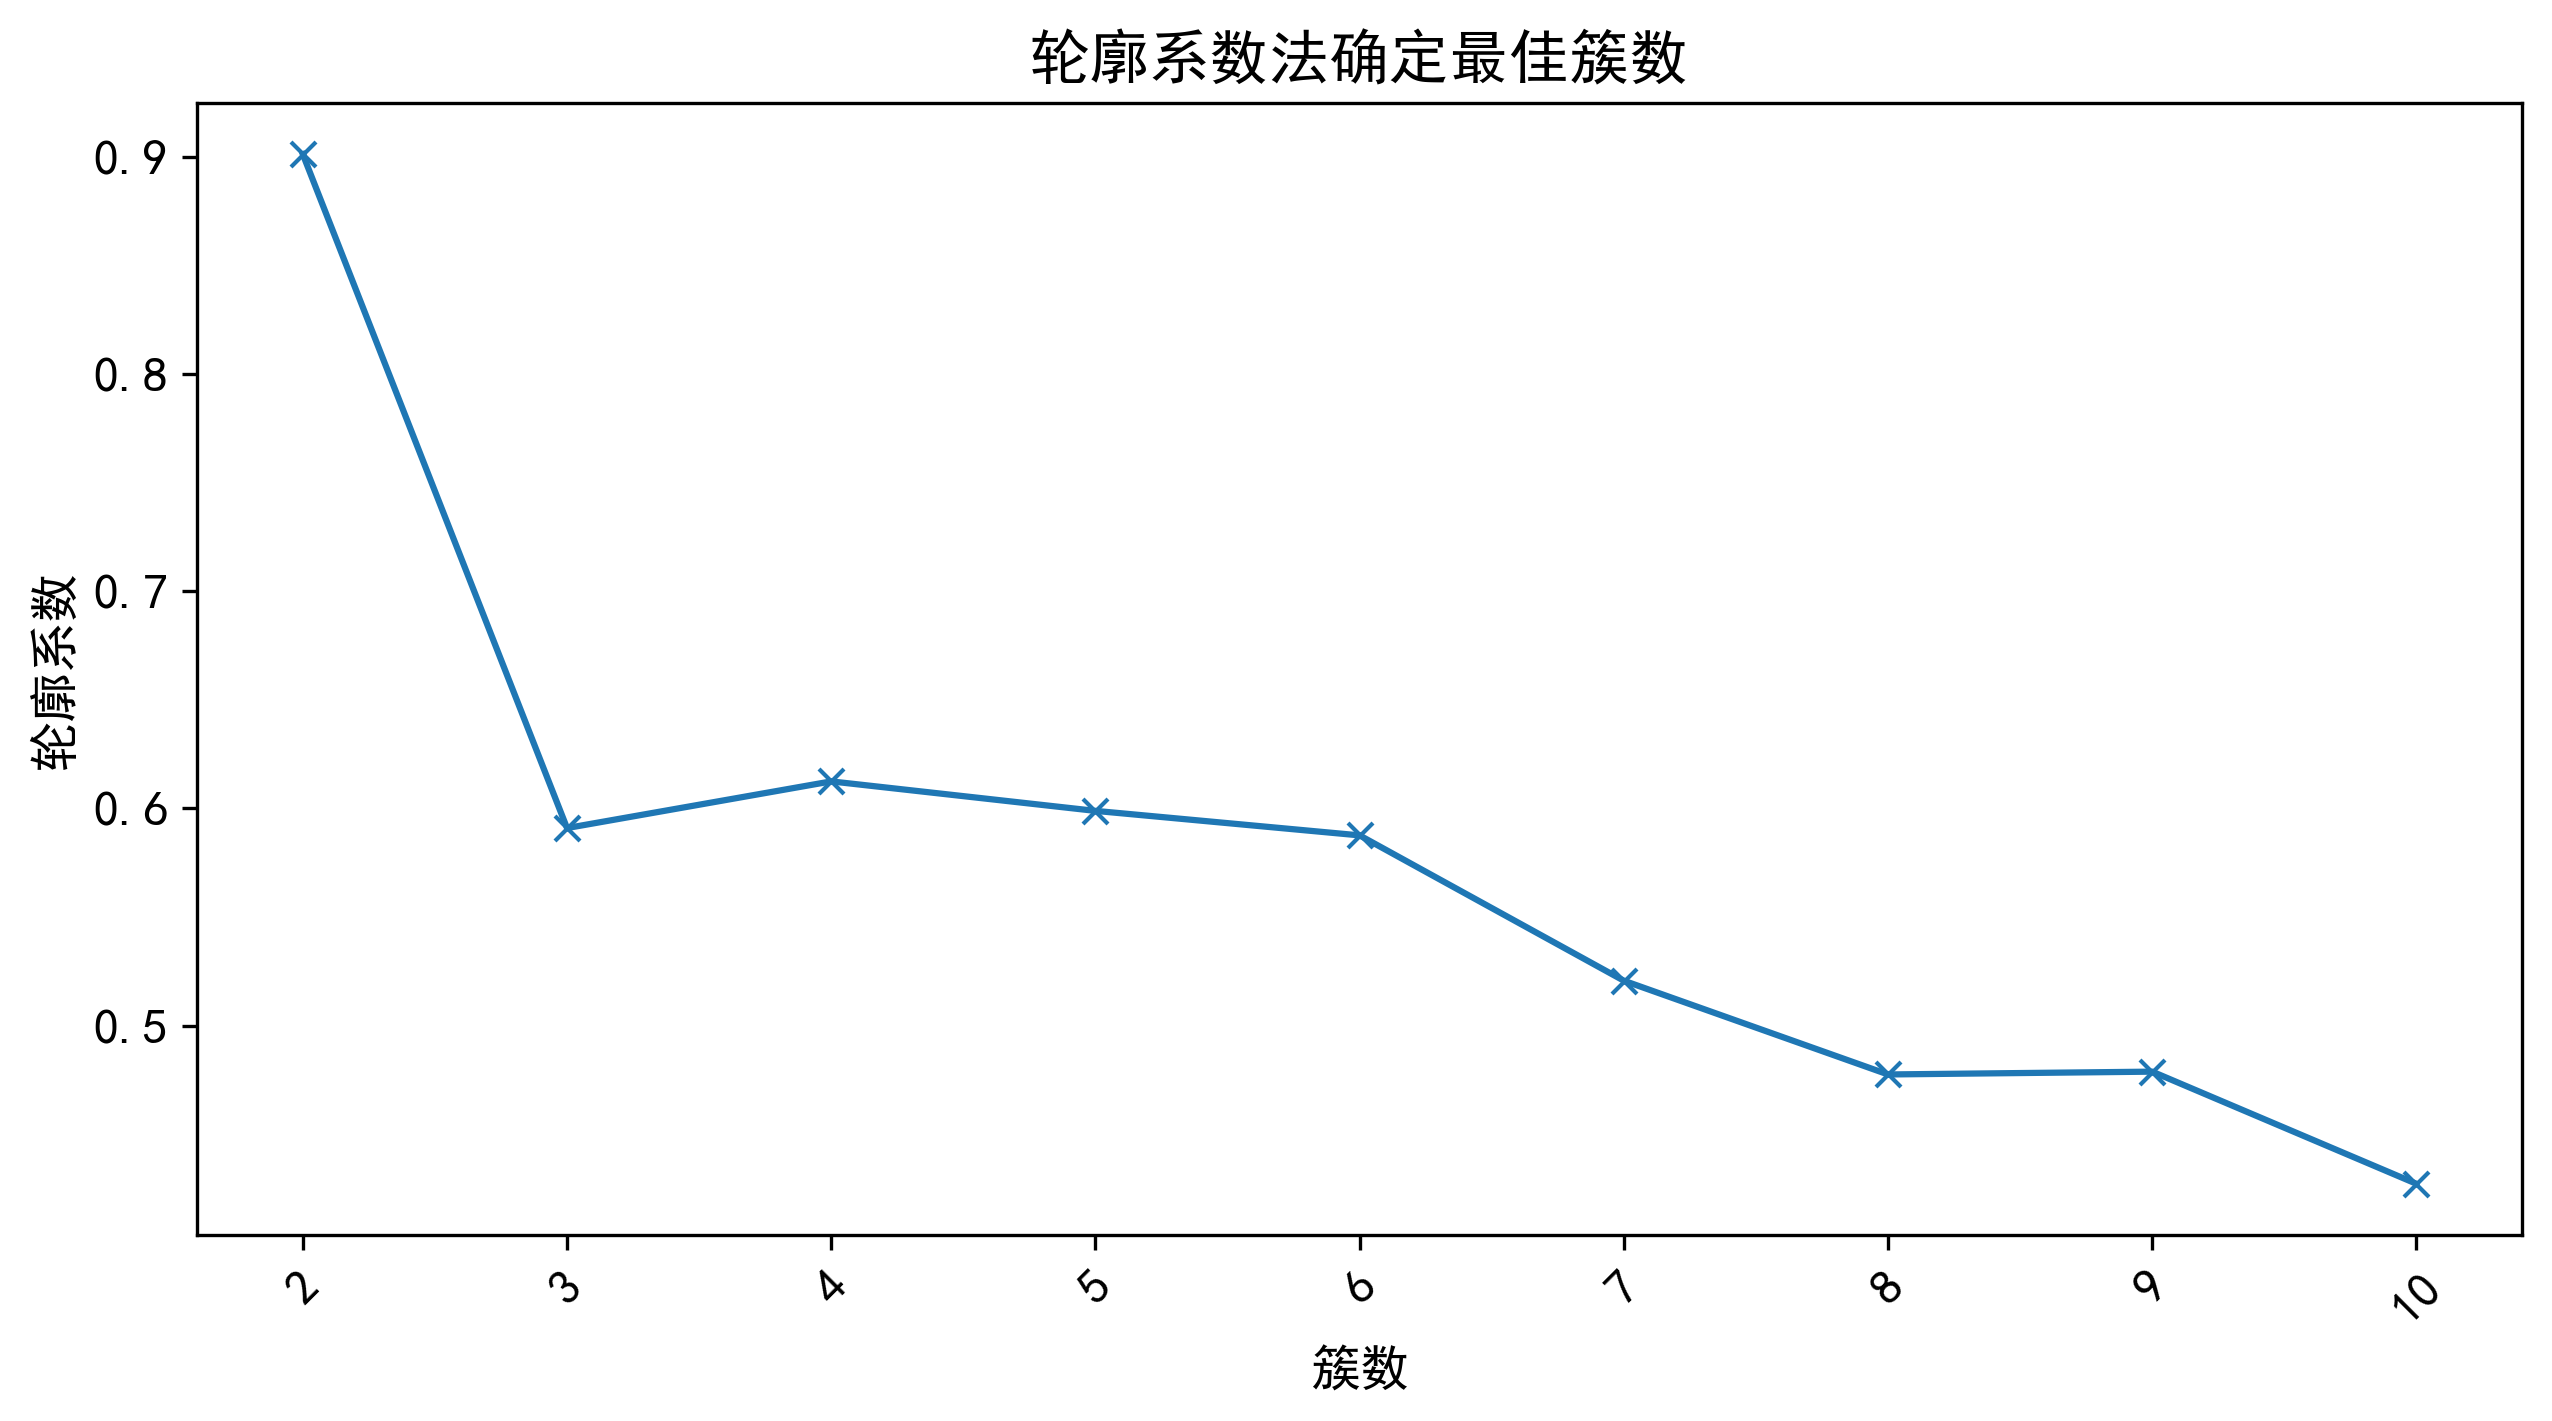

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

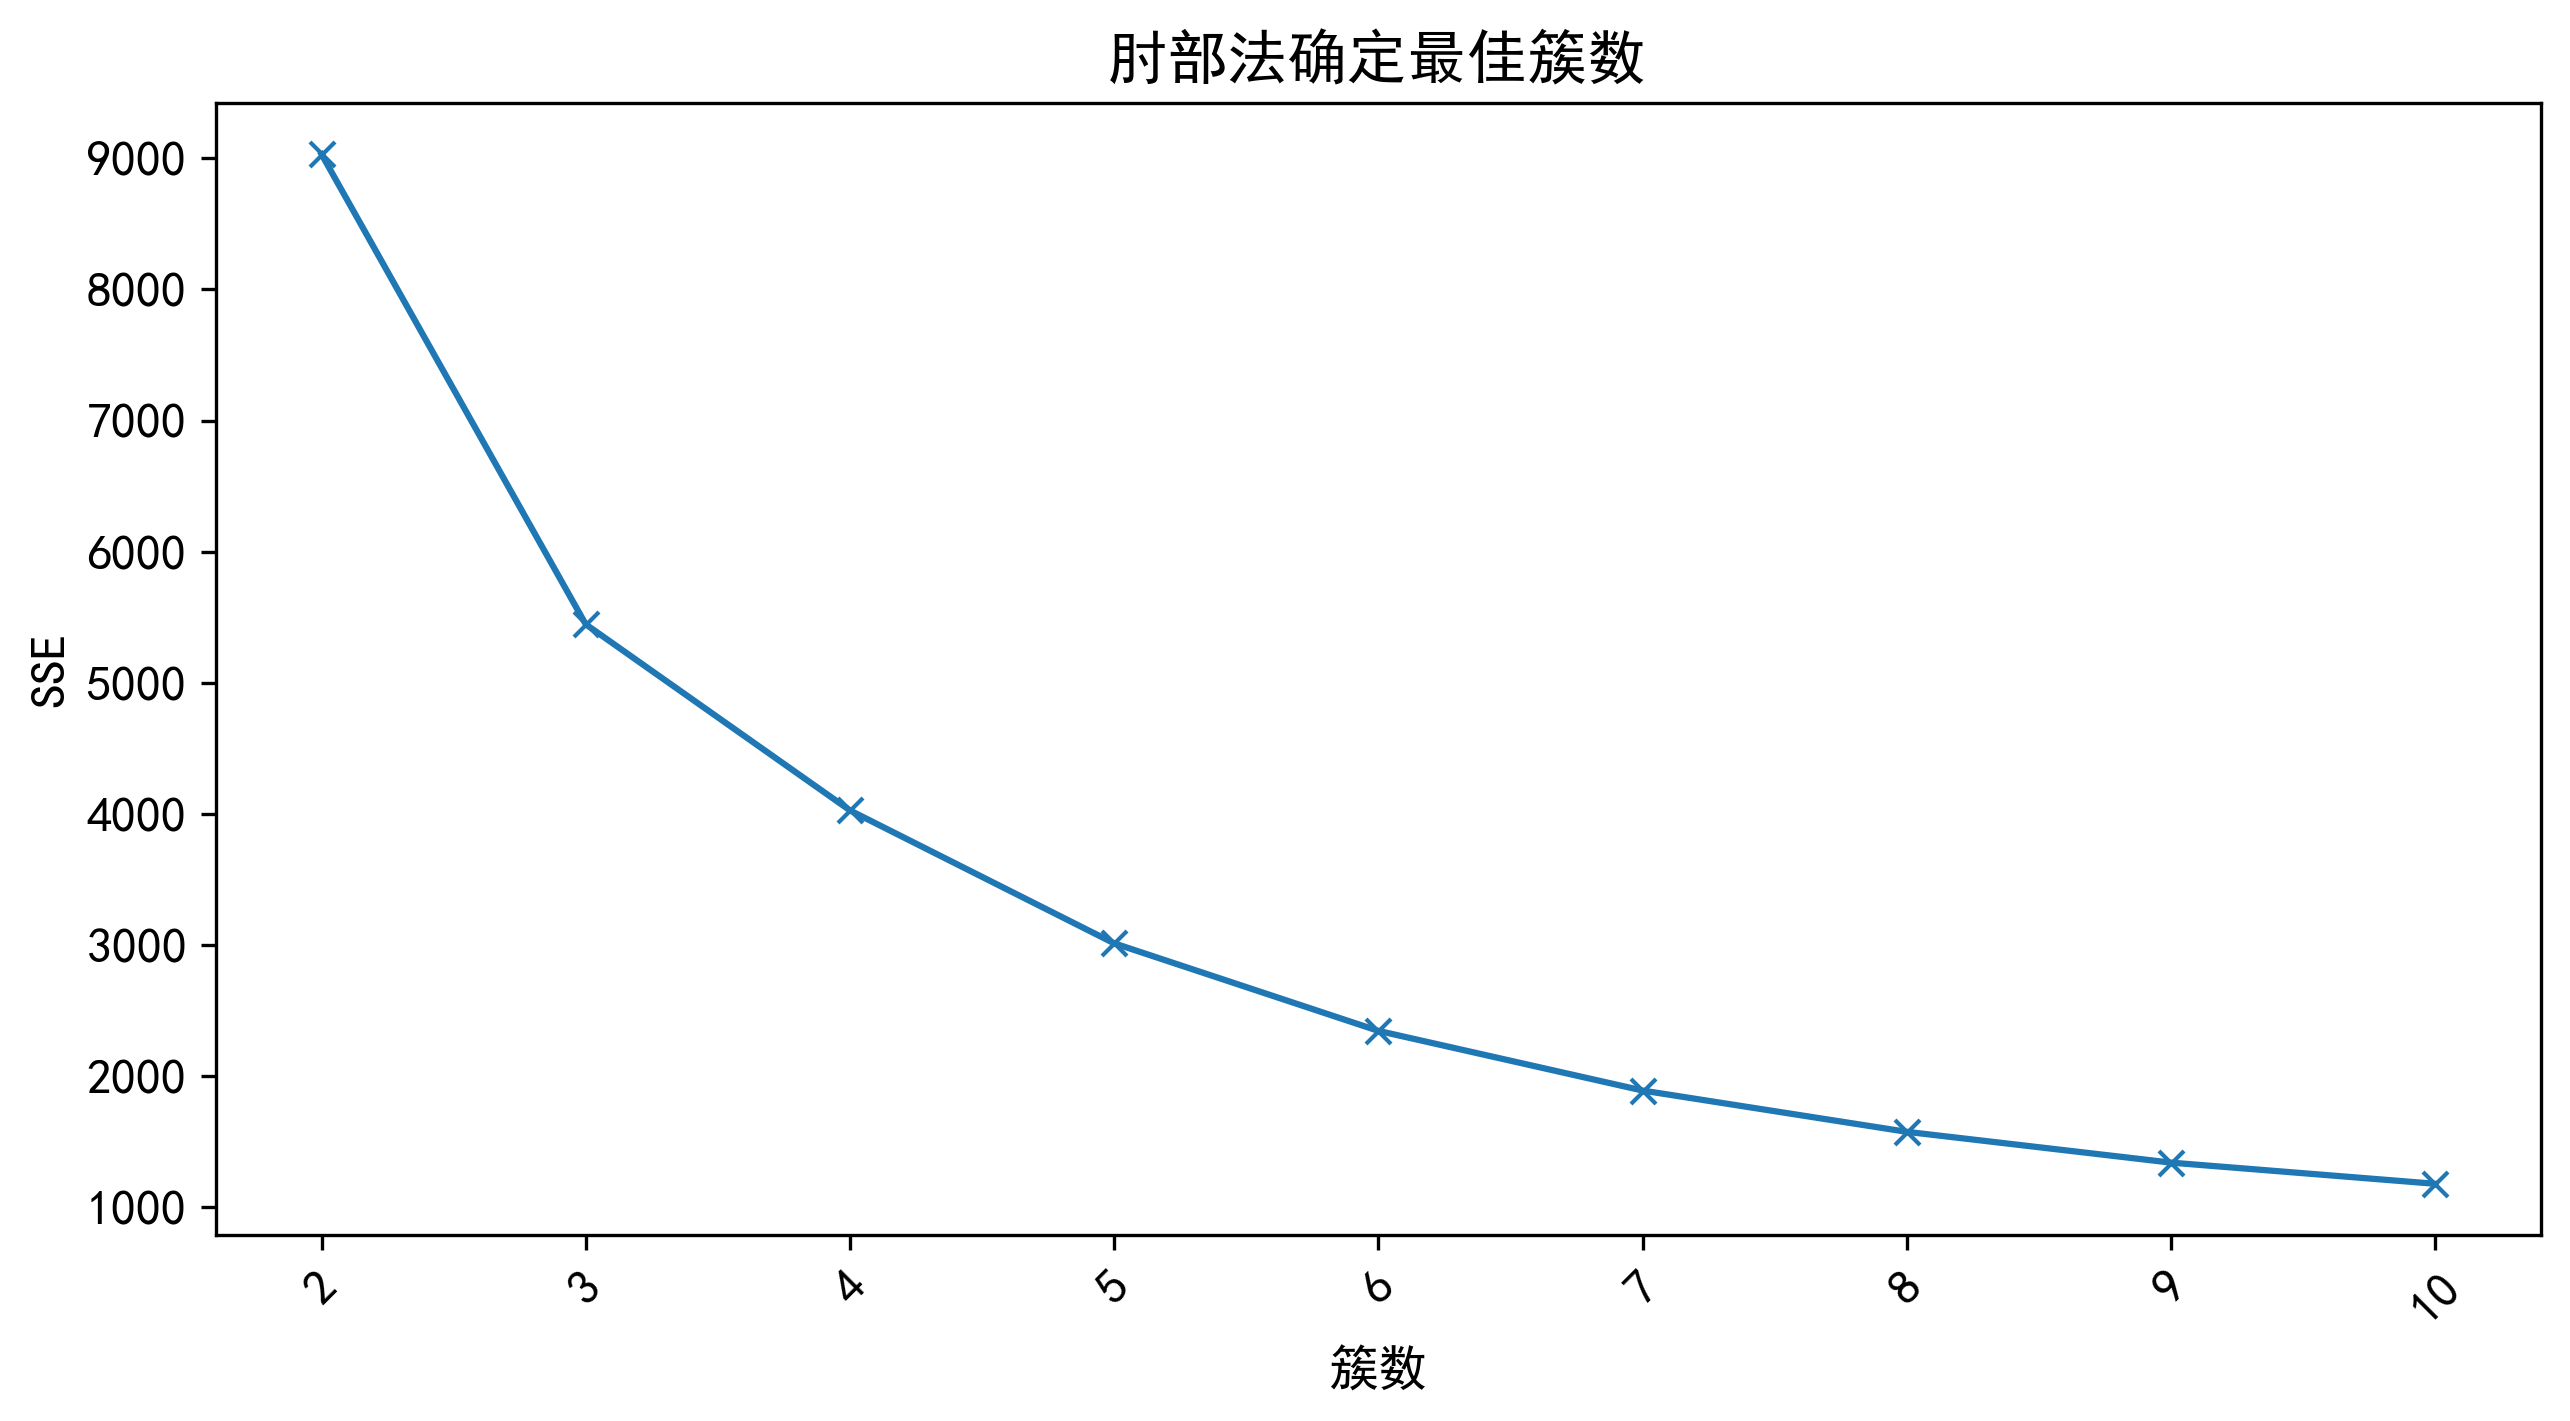

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


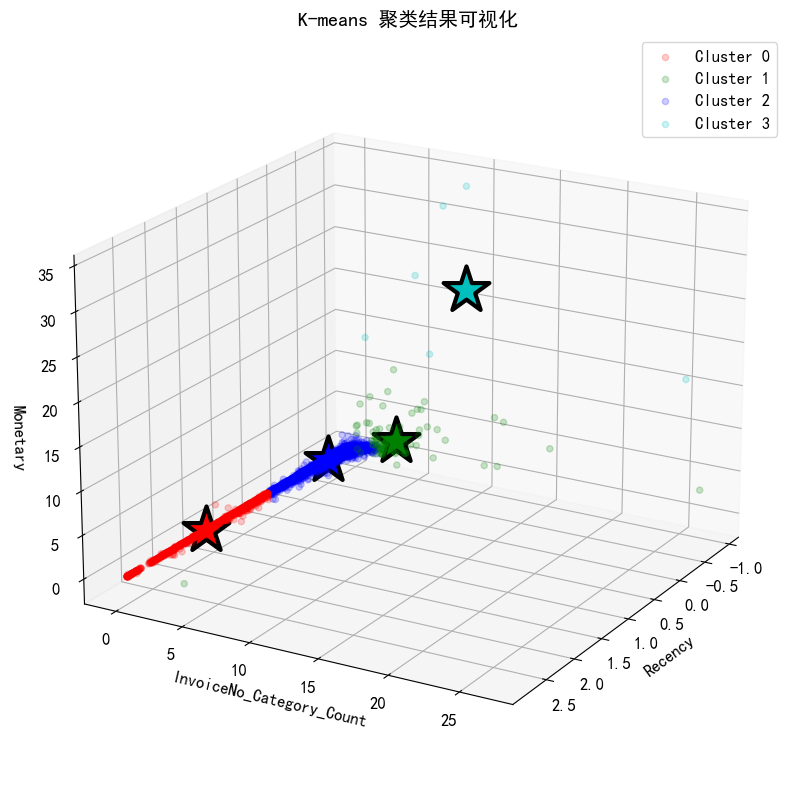

In [37]:
# rfm = clean_df
scaler = StandardScaler()
features = rfm[['Recency', 'InvoiceNo_Category_Count', 'Monetary']]
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=['Recency', 'InvoiceNo_Category_Count', 'Monetary'])
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=28)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='x')
plt.xlabel('簇数')
plt.xticks(rotation=45)
plt.ylabel('轮廓系数')
plt.title('轮廓系数法确定最佳簇数')
plt.show()
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=28)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# 绘制手肘图
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), sse, marker='x')
plt.xlabel('簇数')
plt.xticks(rotation=45)
plt.ylabel('SSE')
plt.title('肘部法确定最佳簇数')
plt.show()

clusters = 4
kmeans = KMeans(n_clusters = clusters , random_state=123)
kmeans.fit(scaled_features_df)
labels = kmeans.labels_
scaled_features_df['Cluster_Label'] = labels

rfm['kmeans_cluster_01'] = labels
# 绘制 3D 可视化图
plt.rcParams['figure.dpi'] = 100
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple']
ax.view_init(elev=20, azim=30)
# 先绘制质心，增大标记大小和轮廓宽度
centroids = kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], c=colors[i], marker='*', s=1200, edgecolor='black', linewidth=3)

# 绘制数据点，降低透明度
for i in range(clusters):
    cluster = scaled_features_df[scaled_features_df['Cluster_Label'] == i]
    ax.scatter(cluster['Recency'], cluster['InvoiceNo_Category_Count'], cluster['Monetary'], c=colors[i],
               label=f'Cluster {i}', alpha=0.2)

ax.set_xlabel('Recency')
ax.set_ylabel('InvoiceNo_Category_Count')
ax.set_zlabel('Monetary')
ax.set_title('K-means 聚类结果可视化')
ax.legend()

plt.show()

In [38]:
rfm

CustomerID     Recency  Recency_Days  InvoiceNo_Category_Count  \
0        12346.0  30031140.0    347.582639                         1   
1        12347.0   2102880.0     24.338889                         7   
2        12348.0   8419620.0     97.449306                         4   
3        12349.0   3506940.0     40.589583                         1   
4        12350.0  28713540.0    332.332639                         1   
...          ...         ...           ...                       ...   
4334     18280.0  25884480.0    299.588889                         1   
4335     18281.0  17500020.0    202.546528                         1   
4336     18282.0   2549820.0     29.511806                         2   
4337     18283.0   2203080.0     25.498611                        16   
4338     18287.0   5581860.0     64.604861                         3   

      InvoiceNo_Total_Count  Monetary  kmeans_cluster_01  
0                         1      0.00                  0  
1                       182   4310.00                  2  
2                        31   1797.24                  2  
3                        73   1757.55                  2  
4                        17    334.40                  0  
...                     ...       ...                ...  
4334                     10    180.60                  0  
4335                      7     80.82                  0  
4336                     12    176.60                  2  
4337                    721   2045.53                  2  
4338                     70   1837.28                  2  

[4339 rows x 7 columns]

In [39]:
rfm['kmeans_cluster_01'].value_counts()

2    3160
0    1077
1      96
3       6
Name: kmeans_cluster_01, dtype: int64

In [40]:
scaled_features_df

Recency  InvoiceNo_Category_Count  Monetary  Cluster_Label
0     2.330924                 -0.424675 -0.231657              0
1    -0.901601                  0.354080  0.290996              2
2    -0.170477                 -0.035297 -0.013714              2
3    -0.739090                 -0.424675 -0.018527              2
4     2.178420                 -0.424675 -0.191106              0
...        ...                       ...       ...            ...
4334  1.850973                 -0.424675 -0.209756              0
4335  0.880523                 -0.424675 -0.221856              0
4336 -0.849871                 -0.294882 -0.210241              2
4337 -0.890004                  1.522213  0.016395              2
4338 -0.498931                 -0.165090 -0.008859              2

[4339 rows x 4 columns]

In [41]:
scaled_features_df.describe().round(3)

Recency  InvoiceNo_Category_Count  Monetary  Cluster_Label
count  4339.000                  4339.000  4339.000       4339.000
mean     -0.000                     0.000     0.000          1.483
std       1.000                     1.000     1.000          0.865
min      -0.920                    -0.425    -0.373          0.000
25%      -0.750                    -0.425    -0.196          1.000
50%      -0.419                    -0.295    -0.153          2.000
75%       0.495                     0.094    -0.035          2.000
max       2.811                    26.702    33.661          3.000

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

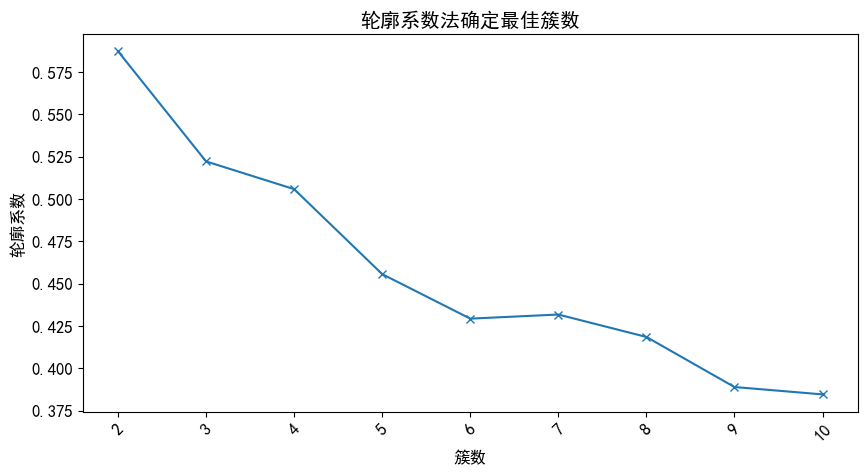

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

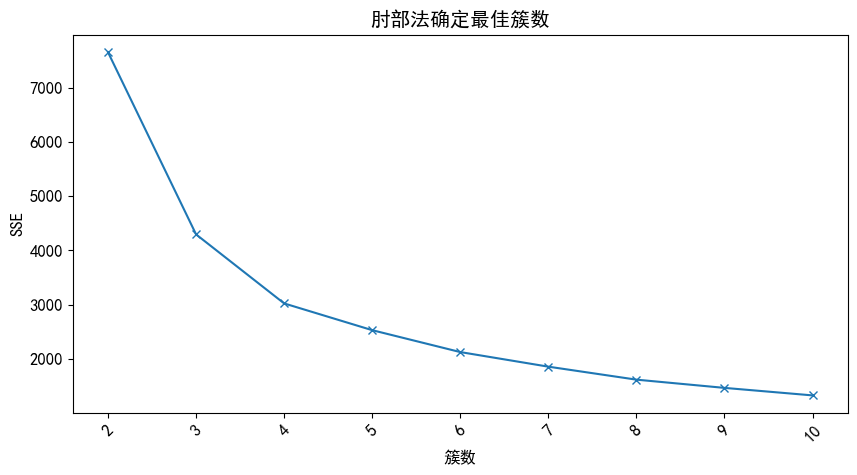

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-42-7f14c366b5af>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['kmeans_cluster_02'] = labels


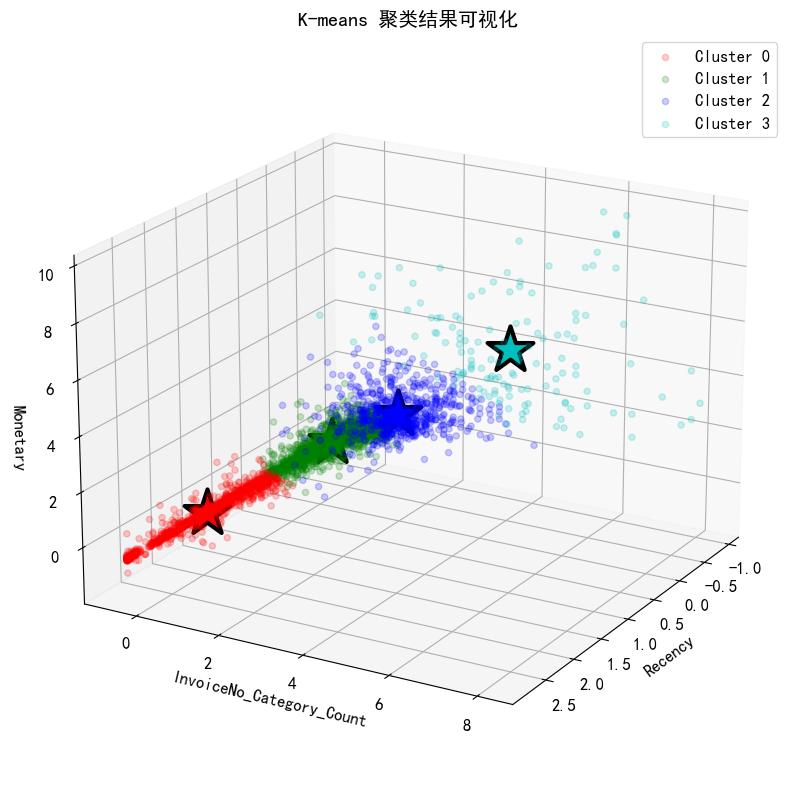

In [42]:
rfm = rfm[~is_outlier]
scaler = StandardScaler()
features = rfm[['Recency', 'InvoiceNo_Category_Count', 'Monetary']]
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=['Recency', 'InvoiceNo_Category_Count', 'Monetary'])
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=28)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='x')
plt.xlabel('簇数')
plt.xticks(rotation=45)
plt.ylabel('轮廓系数')
plt.title('轮廓系数法确定最佳簇数')
plt.show()
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=28)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# 绘制手肘图
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), sse, marker='x')
plt.xlabel('簇数')
plt.xticks(rotation=45)
plt.ylabel('SSE')
plt.title('肘部法确定最佳簇数')
plt.show()

clusters = 4
kmeans = KMeans(n_clusters = clusters , random_state=123)
kmeans.fit(scaled_features_df)
labels = kmeans.labels_
scaled_features_df['Cluster_Label'] = labels

rfm['kmeans_cluster_02'] = labels
# 绘制 3D 可视化图
plt.rcParams['figure.dpi'] = 100
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple']
ax.view_init(elev=20, azim=30)
# 先绘制质心，增大标记大小和轮廓宽度
centroids = kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], c=colors[i], marker='*', s=1200, edgecolor='black', linewidth=3)

# 绘制数据点，降低透明度
for i in range(clusters):
    cluster = scaled_features_df[scaled_features_df['Cluster_Label'] == i]
    ax.scatter(cluster['Recency'], cluster['InvoiceNo_Category_Count'], cluster['Monetary'], c=colors[i],
               label=f'Cluster {i}', alpha=0.2)

ax.set_xlabel('Recency')
ax.set_ylabel('InvoiceNo_Category_Count')
ax.set_zlabel('Monetary')
ax.set_title('K-means 聚类结果可视化')
ax.legend()

plt.show()

In [43]:
rfm

CustomerID     Recency  Recency_Days  InvoiceNo_Category_Count  \
0        12346.0  30031140.0    347.582639                         1   
1        12347.0   2102880.0     24.338889                         7   
2        12348.0   8419620.0     97.449306                         4   
3        12349.0   3506940.0     40.589583                         1   
4        12350.0  28713540.0    332.332639                         1   
...          ...         ...           ...                       ...   
4334     18280.0  25884480.0    299.588889                         1   
4335     18281.0  17500020.0    202.546528                         1   
4336     18282.0   2549820.0     29.511806                         2   
4337     18283.0   2203080.0     25.498611                        16   
4338     18287.0   5581860.0     64.604861                         3   

      InvoiceNo_Total_Count  Monetary  kmeans_cluster_01  kmeans_cluster_02  
0                         1      0.00                  0                  0  
1                       182   4310.00                  2                  2  
2                        31   1797.24                  2                  1  
3                        73   1757.55                  2                  1  
4                        17    334.40                  0                  0  
...                     ...       ...                ...                ...  
4334                     10    180.60                  0                  0  
4335                      7     80.82                  0                  0  
4336                     12    176.60                  2                  1  
4337                    721   2045.53                  2                  2  
4338                     70   1837.28                  2                  1  

[4284 rows x 8 columns]

In [44]:
rfm['kmeans_cluster_02'].value_counts()

1    2409
0    1025
2     708
3     142
Name: kmeans_cluster_02, dtype: int64

In [45]:
scaled_features_df.describe().round(3)

Recency  InvoiceNo_Category_Count  Monetary  Cluster_Label
count  4284.000                  4284.000  4284.000       4284.000
mean     -0.000                     0.000     0.000          0.992
std       1.000                     1.000     1.000          0.733
min      -0.927                    -0.641    -1.267          0.000
25%      -0.749                    -0.641    -0.529          1.000
50%      -0.417                    -0.409    -0.354          1.000
75%       0.502                     0.053     0.104          1.000
max       2.803                     8.152     9.578          3.000

In [46]:
rfm.loc[:, '客户类型'] = rfm['kmeans_cluster_02'].map({
    0: '易流失客户',
    1: '具有发展潜力客户',
    2: '普通客户',
    3: '高价值客户'
})

E:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
E:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [47]:
rfm['客户类型'].value_counts()

具有发展潜力客户    2409
易流失客户       1025
普通客户         708
高价值客户        142
Name: 客户类型, dtype: int64

In [48]:
rfm.to_excel('rfm_classfied.xlsx')

In [50]:
scaled_features_df.to_excel('./scaled_features_df_data.xlsx')

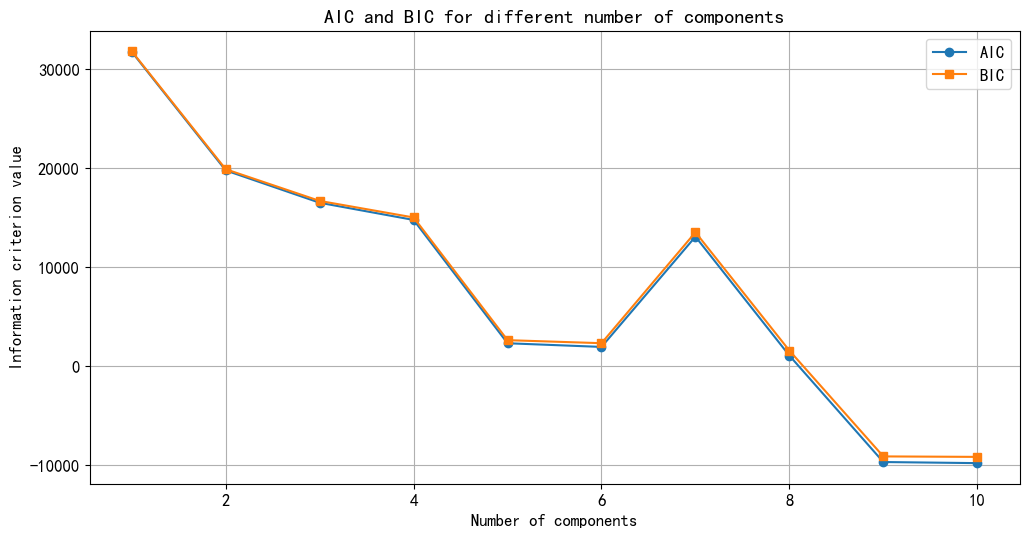

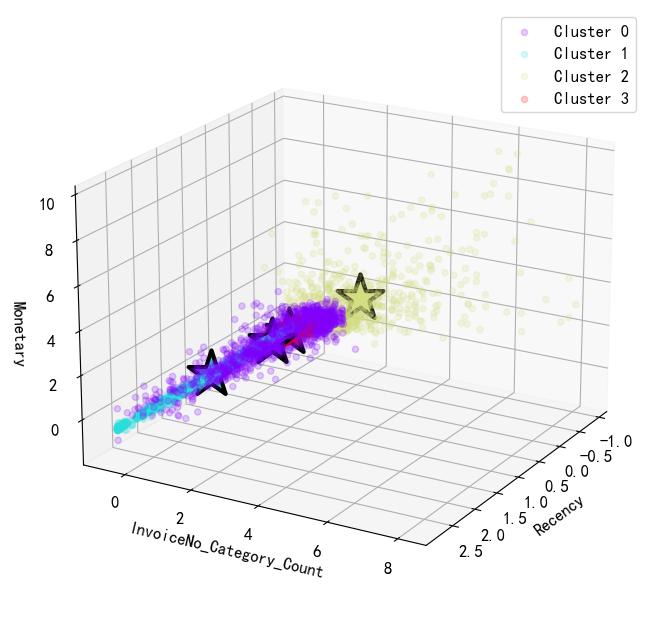

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D

# 读取数据
df = pd.read_excel('./scaled_features_df_data.xlsx')

# 选取特征
X = df[['Recency', 'InvoiceNo_Category_Count', 'Monetary']]

# 定义要尝试的簇数范围
n_components_range = range(1, 11)
aic_values = []
bic_values = []

# 迭代不同的簇数
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=123)
    gmm.fit(X)
    aic = gmm.aic(X)
    bic = gmm.bic(X)
    aic_values.append(aic)
    bic_values.append(bic)

# 绘制 AIC 和 BIC 曲线
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, aic_values, 'o-', label='AIC')
plt.plot(n_components_range, bic_values, 's-', label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Information criterion value')
plt.title('AIC and BIC for different number of components')
plt.legend()
plt.grid(True)
plt.show()

# 选择最优簇数（这里根据 BIC 选择）
# optimal_n_components = np.argmin(bic_values) + 1
optimal_n_components = 4
# 使用最优簇数进行聚类
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=123)
gmm_optimal.fit(X)
df['GMM_Cluster_Label'] = gmm_optimal.predict(X)

# 创建 3D 图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 调整视角，可根据实际情况修改
ax.view_init(elev=20, azim=30)

# 先绘制聚类中心（均值），增大标记大小和轮廓宽度
means = gmm_optimal.means_
colors = plt.cm.rainbow(np.linspace(0, 1, optimal_n_components))
for i, mean in enumerate(means):
    ax.scatter(mean[0], mean[1], mean[2], c=[colors[i]], marker='*', s=1200, edgecolor='black', linewidth=3)

# 绘制散点图，不同类别用不同颜色表示，降低数据点透明度
for i in range(optimal_n_components):
    subset = df[df['GMM_Cluster_Label'] == i]
    ax.scatter(subset['Recency'], subset['InvoiceNo_Category_Count'], subset['Monetary'], c=[colors[i]],
               label=f'Cluster {i}', alpha=0.2)

# 设置轴标签
ax.set_xlabel('Recency')
ax.set_ylabel('InvoiceNo_Category_Count')
ax.set_zlabel('Monetary')

# 添加图例
ax.legend()

# 显示图形
plt.show()
    

In [52]:
df.drop('Cluster_Label',axis=1,inplace=True)

In [53]:
df.loc[:, '客户类型'] = df['GMM_Cluster_Label'].map({
    0: '普通客户',
    1: '易流失客户',
    2: '高价值客户',
    3: '具有发展潜力客户'
})

In [54]:
df['客户类型'].value_counts()

易流失客户       1446
具有发展潜力客户    1297
普通客户        1005
高价值客户        536
Name: 客户类型, dtype: int64

In [56]:
df.describe().round(3)

Unnamed: 0   Recency  InvoiceNo_Category_Count  Monetary  \
count    4284.000  4284.000                  4284.000  4284.000   
mean     2141.500    -0.000                     0.000     0.000   
std      1236.829     1.000                     1.000     1.000   
min         0.000    -0.927                    -0.641    -1.267   
25%      1070.750    -0.749                    -0.641    -0.529   
50%      2141.500    -0.417                    -0.409    -0.354   
75%      3212.250     0.502                     0.053     0.104   
max      4283.000     2.803                     8.152     9.578   

       GMM_Cluster_Label  
count           4284.000  
mean               1.496  
std                1.151  
min                0.000  
25%                1.000  
50%                1.000  
75%                3.000  
max                3.000